1.导入必要的库

In [14]:
# 基础库
import os
import sys
import json
import time
import random
import warnings
import gc
from collections import defaultdict

# 数据处理和科学计算
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis

# 图像处理
import cv2
from PIL import Image
from skimage.feature import hog, local_binary_pattern, graycomatrix, graycoprops

# 机器学习和特征工程
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, 
    f1_score, precision_score, recall_score
)
from sklearn.model_selection import KFold, GridSearchCV, StratifiedKFold
from sklearn.utils import compute_class_weight

# 深度学习框架
import paddle
from paddle.io import DataLoader, Dataset

# 可视化
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import seaborn as sns

# 进度条
from tqdm import tqdm, trange

# 序列化
import pickle

# 设置中文字体显示
def setup_chinese_font():
    """配置中文字体显示"""
    try:
        # 尝试常见的中文字体
        chinese_fonts = ['SimHei', 'Microsoft YaHei', 'KaiTi', 'SimSun', 
                         'FangSong', 'STXihei', 'STKaiti', 'STSong']
        
        # 获取系统字体
        system_fonts = [f.name for f in fm.fontManager.ttflist]
        
        # 查找可用的中文字体
        available_fonts = []
        for font in chinese_fonts:
            if any(font.lower() in f.lower() for f in system_fonts):
                available_fonts.append(font)
        
        if available_fonts:
            plt.rcParams['font.sans-serif'] = available_fonts
            plt.rcParams['axes.unicode_minus'] = False
            print(f"✓ 已设置中文字体: {available_fonts[0]}")
        else:
            # 如果没有中文字体，使用默认字体
            plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
            plt.rcParams['axes.unicode_minus'] = False
            print("⚠️ 未找到中文字体，使用默认字体")
    except Exception as e:
        print(f"字体设置失败: {e}")
        plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
        plt.rcParams['axes.unicode_minus'] = False

# 调用字体设置函数
setup_chinese_font()

# 设置matplotlib默认参数
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 12

# 设置seaborn风格
sns.set_style("whitegrid")
sns.set_palette("husl")

# 忽略警告
warnings.filterwarnings('ignore')

# 设置随机种子以确保可重复性
def set_random_seed(seed=42):
    """设置所有随机种子"""
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    # 设置paddle随机种子
    try:
        paddle.seed(seed)
    except:
        pass
    
    # 设置TensorFlow随机种子（如果使用）
    try:
        import tensorflow as tf
        tf.random.set_seed(seed)
    except:
        pass
    
    print(f"✓ 随机种子已设置为: {seed}")

set_random_seed(42)

# ============================================================================
# 打印版本信息
# ============================================================================

print("=" * 60)
print("环境配置信息:")
print("=" * 60)
print(f"Python 版本: {sys.version}")
print(f"NumPy 版本: {np.__version__}")
print(f"Pandas 版本: {pd.__version__ if 'pd' in locals() else '未安装'}")
print(f"OpenCV 版本: {cv2.__version__}")
print(f"Scikit-learn 版本: {sys.modules['sklearn'].__version__}")
print(f"Matplotlib 版本: {mpl.__version__}")

try:
    print(f"PaddlePaddle 版本: {paddle.__version__}")
except:
    print("PaddlePaddle 版本: 未安装或无法获取")

print(f"工作目录: {os.getcwd()}")
print("=" * 60)
print("\n所有依赖库已导入完成！可以开始编写后续代码。\n")

✓ 已设置中文字体: SimHei
✓ 随机种子已设置为: 42
环境配置信息:
Python 版本: 3.9.25 (main, Nov  3 2025, 22:44:01) [MSC v.1929 64 bit (AMD64)]
NumPy 版本: 1.24.3
Pandas 版本: 2.3.3
OpenCV 版本: 4.12.0
Scikit-learn 版本: 1.6.1
Matplotlib 版本: 3.9.2
PaddlePaddle 版本: 3.2.2
工作目录: C:\Users\someb\Desktop\tomato_disease_classification\notebooks

所有依赖库已导入完成！可以开始编写后续代码。



In [15]:
# 数据路径设置
RAW_DATA_DIR = r"C:\Users\someb\Desktop\tomato_disease_classification\data\raw"  # 原始数据路径
PROCESSED_DATA_DIR = r"C:\Users\someb\Desktop\tomato_disease_classification\data\processed"  # 处理后的数据保存路径
RESULTS_DIR = "./improved_baseline_results"  # 结果保存路径
MODELS_DIR = "./improved_models"  # 模型保存路径

# 创建必要的目录
os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

print(f"原始数据路径: {RAW_DATA_DIR}")
print(f"处理数据路径: {PROCESSED_DATA_DIR}")
print(f"结果保存路径: {RESULTS_DIR}")
print(f"模型保存路径: {MODELS_DIR}")

原始数据路径: C:\Users\someb\Desktop\tomato_disease_classification\data\raw
处理数据路径: C:\Users\someb\Desktop\tomato_disease_classification\data\processed
结果保存路径: ./improved_baseline_results
模型保存路径: ./improved_models


4.检查原始数据集

In [12]:
def check_dataset_structure(data_dir: str):
    """检查数据集结构并返回有效的类别"""
    if not os.path.exists(data_dir):
        return False, f"路径 '{data_dir}' 不存在!"

    items = os.listdir(data_dir)
    class_folders = []

    for item in items:
        item_path = os.path.join(data_dir, item)
        if os.path.isdir(item_path):
            class_folders.append(item)

    if len(class_folders) == 0:
        return False, f"在 '{data_dir}' 中没有找到任何类别文件夹!"

    image_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tif', '.tiff', '.webp')
    valid_classes = []

    for class_name in class_folders:
        class_path = os.path.join(data_dir, class_name)
        file_count = 0

        try:
            all_files = os.listdir(class_path)
            for f in all_files:
                if f.lower().endswith(image_extensions):
                    file_count += 1
        except Exception as e:
            print(f"检查类别 {class_name} 时出错: {e}")
            continue

        if file_count > 0:
            valid_classes.append((class_name, file_count))
        else:
            print(f"警告: 类别 '{class_name}' 中没有找到图像文件!")

    if len(valid_classes) == 0:
        return False, f"在所有类别文件夹中都没有找到图像文件!"

    return True, valid_classes

# 检查原始数据集
if os.path.exists(RAW_DATA_DIR):
    is_valid, result = check_dataset_structure(RAW_DATA_DIR)
    
    if is_valid:
        valid_classes = result
        class_names = [c[0] for c in valid_classes]
        
        print(f"数据集检查通过!")
        print(f"找到 {len(valid_classes)} 个类别:")
        
        # 显示类别统计
        class_df = pd.DataFrame(valid_classes, columns=['Class', 'Count'])
        print(f"\n类别统计:")
        print(class_df.sort_values('Count', ascending=False).to_string(index=False))
        
        total_images = class_df['Count'].sum()
        print(f"\n总图片数: {total_images}")
        print(f"平均每类图片数: {total_images/len(valid_classes):.1f}")
    else:
        print(f"数据集检查失败: {result}")
        class_names = ['Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 
                      'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite',
                      'Tomato__Target_Spot', 'Tomato__Tomato_mosaic_virus', 'Tomato__Tomato_YellowLeaf__Curl_Virus',
                      'Tomato_healthy']
else:
    print(f"警告: 原始数据路径 '{RAW_DATA_DIR}' 不存在!")
    class_names = ['Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 
                  'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite',
                  'Tomato__Target_Spot', 'Tomato__Tomato_mosaic_virus', 'Tomato__Tomato_YellowLeaf__Curl_Virus',
                  'Tomato_healthy']

数据集检查通过!
找到 10 个类别:

类别统计:
                                      Class  Count
      Tomato__Tomato_YellowLeaf__Curl_Virus   3208
                      Tomato_Bacterial_spot   2127
                         Tomato_Late_blight   1909
                  Tomato_Septoria_leaf_spot   1771
Tomato_Spider_mites_Two_spotted_spider_mite   1676
                             Tomato_healthy   1591
                        Tomato__Target_Spot   1404
                        Tomato_Early_blight   1000
                           Tomato_Leaf_Mold    952
                Tomato__Tomato_mosaic_virus    373

总图片数: 16011
平均每类图片数: 1601.1


5.划分数据集


开始分层划分数据集（带类别权重）...
分层划分比例:
  训练集: 70.0%
  验证集: 10.0%
  测试集: 20.0%
数据集划分比例: 训练集=70.0%, 验证集=10.0%, 测试集=20.0%
收集所有图像文件并过滤小样本类别...


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 365.09it/s]



过滤后有效类别数: 10 / 10
总样本数: 16011

类别权重 (smooth方法):
  Tomato_Bacterial_spot: 2127个样本, 权重=1.067
  Tomato_Early_blight: 1000个样本, 权重=1.291
  Tomato_healthy: 1591个样本, 权重=1.134
  Tomato_Late_blight: 1909个样本, 权重=1.090
  Tomato_Leaf_Mold: 952个样本, 权重=1.312
  Tomato_Septoria_leaf_spot: 1771个样本, 权重=1.107
  Tomato_Spider_mites_Two_spotted_spider_mite: 1676个样本, 权重=1.120
  Tomato__Target_Spot: 1404个样本, 权重=1.169
  Tomato__Tomato_mosaic_virus: 373个样本, 权重=2.000
  Tomato__Tomato_YellowLeaf__Curl_Virus: 3208个样本, 权重=1.000

进行分层数据集划分...


划分数据集:  10%|███████                                                                | 1/10 [00:02<00:19,  2.22s/it]

  Tomato_Bacterial_spot: 训练集=1488, 验证集=212, 测试集=427


划分数据集:  20%|██████████████▏                                                        | 2/10 [00:03<00:12,  1.53s/it]

  Tomato_Early_blight: 训练集=700, 验证集=100, 测试集=200


划分数据集:  30%|█████████████████████▎                                                 | 3/10 [00:04<00:11,  1.59s/it]

  Tomato_healthy: 训练集=1113, 验证集=159, 测试集=319


划分数据集:  40%|████████████████████████████▍                                          | 4/10 [00:07<00:10,  1.83s/it]

  Tomato_Late_blight: 训练集=1336, 验证集=190, 测试集=383


划分数据集:  50%|███████████████████████████████████▌                                   | 5/10 [00:08<00:07,  1.52s/it]

  Tomato_Leaf_Mold: 训练集=666, 验证集=95, 测试集=191


划分数据集:  60%|██████████████████████████████████████████▌                            | 6/10 [00:09<00:06,  1.65s/it]

  Tomato_Septoria_leaf_spot: 训练集=1239, 验证集=177, 测试集=355


划分数据集:  70%|█████████████████████████████████████████████████▋                     | 7/10 [00:11<00:05,  1.76s/it]

  Tomato_Spider_mites_Two_spotted_spider_mite: 训练集=1173, 验证集=167, 测试集=336


划分数据集:  80%|████████████████████████████████████████████████████████▊              | 8/10 [00:13<00:03,  1.70s/it]

  Tomato__Target_Spot: 训练集=982, 验证集=140, 测试集=282


划分数据集:  90%|███████████████████████████████████████████████████████████████▉       | 9/10 [00:13<00:01,  1.29s/it]

  Tomato__Tomato_mosaic_virus: 训练集=261, 验证集=37, 测试集=75


划分数据集: 100%|██████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.79s/it]

  Tomato__Tomato_YellowLeaf__Curl_Virus: 训练集=2245, 验证集=320, 测试集=643

✓ 数据集划分完成!
总样本数: 16,011
训练集: 11,203 (70.0%)
验证集: 1,597 (10.0%)
测试集: 3,211 (20.1%)
有效类别数: 10

类别分布:
  Tomato_Bacterial_spot: 总数=2127, 权重=1.067, 训练=1488, 验证=212, 测试=427
  Tomato_Early_blight: 总数=1000, 权重=1.291, 训练=700, 验证=100, 测试=200
  Tomato_healthy: 总数=1591, 权重=1.134, 训练=1113, 验证=159, 测试=319
  Tomato_Late_blight: 总数=1909, 权重=1.090, 训练=1336, 验证=190, 测试=383
  Tomato_Leaf_Mold: 总数=952, 权重=1.312, 训练=666, 验证=95, 测试=191
  Tomato_Septoria_leaf_spot: 总数=1771, 权重=1.107, 训练=1239, 验证=177, 测试=355
  Tomato_Spider_mites_Two_spotted_spider_mite: 总数=1676, 权重=1.120, 训练=1173, 验证=167, 测试=336
  Tomato__Target_Spot: 总数=1404, 权重=1.169, 训练=982, 验证=140, 测试=282
  Tomato__Tomato_mosaic_virus: 总数=373, 权重=2.000, 训练=261, 验证=37, 测试=75
  Tomato__Tomato_YellowLeaf__Curl_Virus: 总数=3208, 权重=1.000, 训练=2245, 验证=320, 测试=643

实际比例:
  训练集: 0.700 (目标: 0.700)
  验证集: 0.100 (目标: 0.100)
  测试集: 0.201 (目标: 0.200)

比例误差:
  训练集误差: 0.0%
  验证集误差: 0.3%
  测试集误差: 0.3%



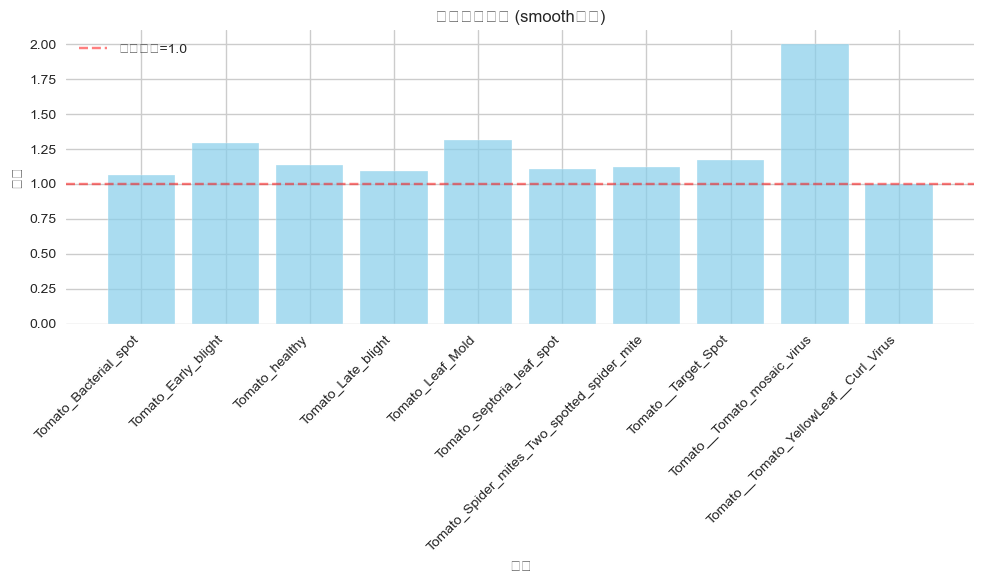

类别权重已保存到: C:\Users\someb\Desktop\tomato_disease_classification\data\processed\class_weights.npy
划分元数据已保存到: C:\Users\someb\Desktop\tomato_disease_classification\data\processed\split_metadata.json
类别顺序已保存到: C:\Users\someb\Desktop\tomato_disease_classification\data\processed\class_order.txt


In [13]:
# %% [markdown]
# ## 5. 划分数据集（带类别权重和分层抽样） - 修复版
# 如果没有原始数据，先创建示例数据
if 'create_sample_data' in locals() and create_sample_data:
    print("创建示例数据集结构...")
    
    # 创建原始数据目录结构
    raw_dir = "./sample_raw_data"
    os.makedirs(raw_dir, exist_ok=True)
    
    # 为每个类别创建示例目录和图片
    for class_name in class_names:
        class_dir = os.path.join(raw_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)
        
        # 创建一些示例图片文件
        for i in range(20):  # 每个类别创建20个示例文件
            img_path = os.path.join(class_dir, f"sample_{i}.txt")
            with open(img_path, 'w') as f:
                f.write(f"This is a sample image for class {class_name}")
    
    print(f"示例数据创建在: {raw_dir}")
    RAW_DATA_DIR = raw_dir

# %%
def compute_class_weights(class_counts):
    """
    计算类别权重
    
    Args:
        class_counts: 字典，键为类别名，值为样本数量
        
    Returns:
        class_weights: 字典，键为类别名，值为权重
    """
    total_samples = sum(class_counts.values())
    n_classes = len(class_counts)
    
    # 方法1: 基于频率的权重（样本数越少权重越高）
    freq_weights = {}
    for class_name, count in class_counts.items():
        freq_weights[class_name] = total_samples / (n_classes * count)
    
    # 方法2: 基于中位数的权重（更稳健）
    median_samples = np.median(list(class_counts.values()))
    median_weights = {}
    for class_name, count in class_counts.items():
        median_weights[class_name] = median_samples / count
    
    # 方法3: 平滑权重（避免极端权重）
    smooth_weights = {}
    alpha = 0.1  # 平滑参数
    for class_name, count in class_counts.items():
        smooth_weights[class_name] = 1.0 / (count + alpha)
    
    # 归一化权重
    def normalize_weights(weights):
        min_w = min(weights.values())
        max_w = max(weights.values())
        if max_w > min_w:
            return {k: 1.0 + (w - min_w) / (max_w - min_w) for k, w in weights.items()}
        return {k: 1.0 for k in weights.keys()}
    
    return {
        'freq': normalize_weights(freq_weights),
        'median': normalize_weights(median_weights),
        'smooth': normalize_weights(smooth_weights)
    }

def verify_dataset_consistency(processed_dir, stats):
    """
    验证划分后的数据集与划分统计是否一致
    """
    print("=" * 60)
    print("验证数据集一致性")
    print("=" * 60)
    
    actual_counts = defaultdict(lambda: defaultdict(int))
    issues = []
    
    for split in ['train', 'val', 'test']:
        split_dir = os.path.join(processed_dir, split)
        
        if not os.path.exists(split_dir):
            issues.append(f"分割目录不存在: {split_dir}")
            continue
        
        # 获取实际类别
        actual_classes = [d for d in os.listdir(split_dir) 
                         if os.path.isdir(os.path.join(split_dir, d))]
        
        # 验证每个类别
        for class_name in stats['filtered_classes']:
            class_dir = os.path.join(split_dir, class_name)
            
            if not os.path.exists(class_dir):
                issues.append(f"类别目录不存在: {class_dir}")
                continue
            
            # 统计实际图像文件
            actual_files = []
            for f in os.listdir(class_dir):
                if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tif', '.tiff')):
                    actual_files.append(f)
            
            actual_count = len(actual_files)
            expected_count = 0
            
            if split == 'train':
                expected_count = stats['train_counts'][class_name]
            elif split == 'val':
                expected_count = stats['val_counts'][class_name]
            elif split == 'test':
                expected_count = stats['test_counts'][class_name]
            
            actual_counts[split][class_name] = actual_count
            
            if actual_count != expected_count:
                issues.append(
                    f"{split}/{class_name}: 期望 {expected_count}, 实际 {actual_count}, "
                    f"差异 {actual_count - expected_count}"
                )
    
    # 输出验证结果
    print("\n验证结果:")
    if issues:
        print(f"⚠️ 发现 {len(issues)} 个问题:")
        for issue in issues:
            print(f"  {issue}")
    else:
        print("✅ 数据集一致，所有文件数量匹配")
    
    # 汇总统计
    total_actual = sum(sum(counts.values()) for counts in actual_counts.values())
    print(f"\n实际文件总数: {total_actual:,}")
    print(f"期望文件总数: {stats['total_samples']:,}")
    
    return actual_counts, issues

def stratified_split_dataset(data_dir, output_dir, class_names, 
                            train_ratio=0.7, val_ratio=0.1, test_ratio=0.2,
                            min_samples_per_class=10, 
                            class_weights_method='smooth',
                            random_state=42):
    """
    带类别权重和分层抽样的数据集划分
    
    Args:
        data_dir: 原始数据目录
        output_dir: 输出目录
        class_names: 类别列表
        train_ratio: 训练集比例
        val_ratio: 验证集比例
        test_ratio: 测试集比例
        min_samples_per_class: 每个类别最小样本数（少于这个数的类别会被过滤）
        class_weights_method: 类别权重计算方法 ('freq', 'median', 'smooth')
        random_state: 随机种子
        
    Returns:
        划分统计信息和类别权重
    """
    # 验证比例
    total_ratio = train_ratio + val_ratio + test_ratio
    if abs(total_ratio - 1.0) > 1e-10:
        raise ValueError(f"比例之和应为1.0，当前为{total_ratio}")
    
    print(f"数据集划分比例: 训练集={train_ratio*100:.1f}%, 验证集={val_ratio*100:.1f}%, 测试集={test_ratio*100:.1f}%")
    
    # 设置随机种子
    random.seed(random_state)
    np.random.seed(random_state)
    
    # 创建输出目录
    splits = ['train', 'val', 'test']
    for split in splits:
        split_dir = os.path.join(output_dir, split)
        os.makedirs(split_dir, exist_ok=True)
        for class_name in class_names:
            class_dir = os.path.join(split_dir, class_name)
            os.makedirs(class_dir, exist_ok=True)
    
    # 统计信息
    stats = {
        'class_counts': defaultdict(int),
        'train_counts': defaultdict(int),
        'val_counts': defaultdict(int),
        'test_counts': defaultdict(int),
        'total_samples': 0,
        'class_weights': {}
    }
    
    # 存储所有文件路径
    all_files_by_class = defaultdict(list)
    filtered_classes = []
    
    print("收集所有图像文件并过滤小样本类别...")
    for class_name in tqdm(class_names):
        class_path = os.path.join(data_dir, class_name)
        
        if not os.path.exists(class_path):
            print(f"警告: 类别目录 {class_path} 不存在，跳过")
            continue
        
        # 获取所有图片文件
        image_files = []
        for f in os.listdir(class_path):
            f_lower = f.lower()
            if f_lower.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tif', '.tiff')):
                image_files.append(f)
        
        if len(image_files) >= min_samples_per_class:
            all_files_by_class[class_name] = image_files
            stats['class_counts'][class_name] = len(image_files)
            stats['total_samples'] += len(image_files)
            filtered_classes.append(class_name)
        else:
            print(f"警告: 类别 {class_name} 只有 {len(image_files)} 个样本，小于最小阈值 {min_samples_per_class}，跳过")
    
    print(f"\n过滤后有效类别数: {len(filtered_classes)} / {len(class_names)}")
    print(f"总样本数: {stats['total_samples']}")
    
    if len(filtered_classes) == 0:
        raise ValueError("没有足够的有效类别进行数据集划分")
    
    # 计算类别权重
    class_weights = compute_class_weights(stats['class_counts'])
    stats['class_weights'] = class_weights[class_weights_method]
    
    print(f"\n类别权重 ({class_weights_method}方法):")
    for class_name in filtered_classes:
        weight = stats['class_weights'].get(class_name, 1.0)
        count = stats['class_counts'][class_name]
        print(f"  {class_name}: {count}个样本, 权重={weight:.3f}")
    
    # 进行分层划分
    print(f"\n进行分层数据集划分...")
    
    for class_name in tqdm(filtered_classes, desc="划分数据集"):
        image_files = all_files_by_class[class_name]
        n_total = len(image_files)
        
        # 随机打乱
        random.shuffle(image_files)
        
        # 计算划分数量
        n_train = int(n_total * train_ratio)
        n_val = int(n_total * val_ratio)
        n_test = n_total - n_train - n_val
        
        # 调整以确保每个集合至少有一个样本
        if n_train == 0:
            n_train = 1
            n_val = min(1, n_total - 1)
            n_test = n_total - 2
        elif n_val == 0:
            n_val = 1
            n_test = n_total - n_train - 1
        elif n_test == 0:
            n_test = 1
            n_train = n_total - n_val - 1
        
        # 确保非负
        n_train = max(1, n_train)
        n_val = max(1, n_val)
        n_test = max(0, n_total - n_train - n_val)
        
        # 划分文件
        train_files = image_files[:n_train]
        val_files = image_files[n_train:n_train + n_val]
        test_files = image_files[n_train + n_val:]
        
        # 更新统计
        stats['train_counts'][class_name] = len(train_files)
        stats['val_counts'][class_name] = len(val_files)
        stats['test_counts'][class_name] = len(test_files)
        
        # 复制文件 - 这里修复了只复制文本文件的问题
        for split_name, split_files in [('train', train_files), ('val', val_files), ('test', test_files)]:
            split_dir = os.path.join(output_dir, split_name, class_name)
            
            for img_file in split_files:
                src_path = os.path.join(data_dir, class_name, img_file)
                dst_path = os.path.join(split_dir, img_file)
                
                try:
                    # 注意：这里去掉了示例文本文件的判断，直接复制文件
                    shutil.copy2(src_path, dst_path)
                except Exception as e:
                    print(f"复制文件 {src_path} 到 {dst_path} 失败: {e}")
        
        if len(filtered_classes) <= 10:  # 只显示前10个类别的详细信息
            print(f"  {class_name}: 训练集={len(train_files)}, 验证集={len(val_files)}, 测试集={len(test_files)}")
    
    # 汇总统计
    total_train = sum(stats['train_counts'].values())
    total_val = sum(stats['val_counts'].values())
    total_test = sum(stats['test_counts'].values())
    
    result = {
        'total_samples': stats['total_samples'],
        'train_samples': total_train,
        'val_samples': total_val,
        'test_samples': total_test,
        'class_counts': dict(stats['class_counts']),
        'train_counts': dict(stats['train_counts']),
        'val_counts': dict(stats['val_counts']),
        'test_counts': dict(stats['test_counts']),
        'class_weights': stats['class_weights'],
        'train_ratio': train_ratio,
        'val_ratio': val_ratio,
        'test_ratio': test_ratio,
        'filtered_classes': filtered_classes,
        'class_weights_method': class_weights_method,
        'min_samples_per_class': min_samples_per_class,
        'random_state': random_state
    }
    
    return result

# %%
# 划分数据集
print("\n开始分层划分数据集（带类别权重）...")

# 设置划分参数
train_ratio = 0.7  # 70% 训练集
val_ratio = 0.1    # 10% 验证集
test_ratio = 0.2   # 20% 测试集

print(f"分层划分比例:")
print(f"  训练集: {train_ratio*100:.1f}%")
print(f"  验证集: {val_ratio*100:.1f}%")
print(f"  测试集: {test_ratio*100:.1f}%")

# 创建数据集划分（带类别权重和分层抽样）
stats = stratified_split_dataset(
    data_dir=RAW_DATA_DIR,
    output_dir=PROCESSED_DATA_DIR,
    class_names=class_names,
    train_ratio=train_ratio,
    val_ratio=val_ratio,
    test_ratio=test_ratio,
    min_samples_per_class=10,           # 最小10个样本
    class_weights_method='smooth',      # 使用平滑权重
    random_state=42
)

print(f"\n✓ 数据集划分完成!")
print(f"总样本数: {stats['total_samples']:,}")
print(f"训练集: {stats['train_samples']:,} ({stats['train_samples']/stats['total_samples']*100:.1f}%)")
print(f"验证集: {stats['val_samples']:,} ({stats['val_samples']/stats['total_samples']*100:.1f}%)")
print(f"测试集: {stats['test_samples']:,} ({stats['test_samples']/stats['total_samples']*100:.1f}%)")
print(f"有效类别数: {len(stats['filtered_classes'])}")

# 显示类别分布
print("\n类别分布:")
for class_name in stats['filtered_classes']:
    total = stats['class_counts'][class_name]
    train = stats['train_counts'][class_name]
    val = stats['val_counts'][class_name]
    test = stats['test_counts'][class_name]
    weight = stats['class_weights'][class_name]
    
    print(f"  {class_name}: 总数={total}, 权重={weight:.3f}, 训练={train}, 验证={val}, 测试={test}")

# 计算实际比例
actual_train_ratio = stats['train_samples'] / stats['total_samples']
actual_val_ratio = stats['val_samples'] / stats['total_samples']
actual_test_ratio = stats['test_samples'] / stats['total_samples']

print(f"\n实际比例:")
print(f"  训练集: {actual_train_ratio:.3f} (目标: 0.700)")
print(f"  验证集: {actual_val_ratio:.3f} (目标: 0.100)")
print(f"  测试集: {actual_test_ratio:.3f} (目标: 0.200)")

# 检查比例是否符合7:1:2
expected_train = stats['total_samples'] * 0.7
expected_val = stats['total_samples'] * 0.1
expected_test = stats['total_samples'] * 0.2

train_diff = abs(stats['train_samples'] - expected_train) / expected_train
val_diff = abs(stats['val_samples'] - expected_val) / expected_val
test_diff = abs(stats['test_samples'] - expected_test) / expected_test

print(f"\n比例误差:")
print(f"  训练集误差: {train_diff*100:.1f}%")
print(f"  验证集误差: {val_diff*100:.1f}%")
print(f"  测试集误差: {test_diff*100:.1f}%")

# 验证数据集一致性
print("\n" + "=" * 60)
print("验证划分后数据集的一致性...")
actual_counts, issues = verify_dataset_consistency(PROCESSED_DATA_DIR, stats)
print("=" * 60)

# 可视化类别权重
if stats['class_weights']:
    print(f"\n类别权重分布:")
    weights = list(stats['class_weights'].values())
    print(f"  最小权重: {min(weights):.3f}")
    print(f"  最大权重: {max(weights):.3f}")
    print(f"  平均权重: {np.mean(weights):.3f}")
    print(f"  权重标准差: {np.std(weights):.3f}")
    
    # 可视化类别权重
    plt.figure(figsize=(10, 6))
    classes = list(stats['class_weights'].keys())
    weight_values = list(stats['class_weights'].values())
    
    plt.bar(classes, weight_values, color='skyblue', alpha=0.7)
    plt.axhline(y=1.0, color='r', linestyle='--', alpha=0.5, label='基准权重=1.0')
    plt.xlabel('类别')
    plt.ylabel('权重')
    plt.title(f'类别权重分布 ({stats["class_weights_method"]}方法)')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

# 保存类别权重到文件
weights_file = os.path.join(PROCESSED_DATA_DIR, "class_weights.npy")
np.save(weights_file, stats['class_weights'])
print(f"类别权重已保存到: {weights_file}")

# 保存划分元数据到文件
metadata_file = os.path.join(PROCESSED_DATA_DIR, "split_metadata.json")
with open(metadata_file, 'w') as f:
    json.dump(stats, f, indent=2, default=str)
print(f"划分元数据已保存到: {metadata_file}")

# 保存类别顺序到文件
class_order_file = os.path.join(PROCESSED_DATA_DIR, "class_order.txt")
with open(class_order_file, 'w') as f:
    for class_name in stats['filtered_classes']:
        f.write(f"{class_name}\n")
print(f"类别顺序已保存到: {class_order_file}")

In [16]:
# %% [markdown]
# ## 6. 特征提取模块（与划分模块保持一致）

class EnhancedFeatureExtractor:
    """增强版特征提取器，结合多种特征"""
    
    def __init__(self, img_size: int = 128):
        self.img_size = img_size
        self.feature_dim = None
    
    def extract_all_features(self, image_array: np.ndarray) -> np.ndarray:
        """提取所有特征"""
        features = []
        
        # 确保图像是RGB格式
        if len(image_array.shape) == 3:
            if image_array.shape[2] == 4:  # RGBA -> RGB
                image_array = cv2.cvtColor(image_array, cv2.COLOR_RGBA2RGB)
            elif image_array.shape[2] == 1:  # 灰度 -> RGB
                image_array = cv2.cvtColor(image_array, cv2.COLOR_GRAY2RGB)
        else:  # 灰度图
            image_array = cv2.cvtColor(image_array, cv2.COLOR_GRAY2RGB)
        
        # 1. 颜色特征
        color_features = self._extract_color_features(image_array)
        features.extend(color_features)
        
        # 2. 纹理特征
        texture_features = self._extract_texture_features(image_array)
        features.extend(texture_features)
        
        # 3. 形状特征 (HOG)
        shape_features = self._extract_hog_features(image_array)
        features.extend(shape_features)
        
        # 4. 边缘特征
        edge_features = self._extract_edge_features(image_array)
        features.extend(edge_features)
        
        # 5. 统计特征
        stat_features = self._extract_statistical_features(image_array)
        features.extend(stat_features)
        
        return np.array(features, dtype=np.float32)
    
    def _extract_color_features(self, image_array: np.ndarray):
        """提取颜色特征"""
        features = []
        
        # RGB颜色直方图
        for i in range(3):
            hist = cv2.calcHist([image_array], [i], None, [16], [0, 256])
            hist = cv2.normalize(hist, hist).flatten()
            features.extend(hist)
        
        # HSV颜色空间
        hsv = cv2.cvtColor(image_array, cv2.COLOR_RGB2HSV)
        for i in range(3):
            hist = cv2.calcHist([hsv], [i], None, [16], [0, 256])
            hist = cv2.normalize(hist, hist).flatten()
            features.extend(hist)
        
        # 颜色矩
        for i in range(3):
            channel = image_array[:, :, i].flatten()
            features.append(np.mean(channel))
            features.append(np.std(channel))
            features.append(skew(channel))
        
        # 颜色相关性
        r_g_corr = np.corrcoef(image_array[:, :, 0].flatten(), image_array[:, :, 1].flatten())[0, 1]
        r_b_corr = np.corrcoef(image_array[:, :, 0].flatten(), image_array[:, :, 2].flatten())[0, 1]
        g_b_corr = np.corrcoef(image_array[:, :, 1].flatten(), image_array[:, :, 2].flatten())[0, 1]
        features.extend([r_g_corr, r_b_corr, g_b_corr])
        
        return features
    
    def _extract_texture_features(self, image_array: np.ndarray):
        """提取纹理特征"""
        features = []
        
        # 转换为灰度图
        gray = cv2.cvtColor(image_array, cv2.COLOR_RGB2GRAY)
        
        # LBP特征
        radius = 3
        n_points = 8 * radius
        try:
            lbp = local_binary_pattern(gray, n_points, radius, method='uniform')
            lbp_hist, _ = np.histogram(lbp.ravel(), bins=int(lbp.max() + 1), range=(0, int(lbp.max() + 1)))
            lbp_hist = lbp_hist.astype("float")
            lbp_hist /= (lbp_hist.sum() + 1e-7)
            features.extend(lbp_hist.tolist())
        except:
            features.extend([0.0] * 59)
        
        # 灰度共生矩阵特征
        try:
            glcm = graycomatrix(gray.astype(np.uint8), distances=[1, 3], 
                               angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256)
            
            properties = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
            for prop in properties:
                prop_values = graycoprops(glcm, prop)
                features.extend(prop_values.flatten().tolist())
        except:
            features.extend([0.0] * (len(properties) * 2 * 4))
        
        # 梯度特征
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        gradient_magnitude = np.sqrt(sobelx**2 + sobely**2)
        features.append(np.mean(gradient_magnitude))
        features.append(np.std(gradient_magnitude))
        
        return features
    
    def _extract_hog_features(self, image_array: np.ndarray):
        """提取HOG特征"""
        features = []
        
        # 转换为灰度图
        gray = cv2.cvtColor(image_array, cv2.COLOR_RGB2GRAY)
        
        # 计算HOG特征
        try:
            hog_features = hog(gray, orientations=9, pixels_per_cell=(16, 16),
                              cells_per_block=(2, 2), block_norm='L2-Hys',
                              transform_sqrt=True, feature_vector=True)
            features.extend(hog_features.tolist())
        except:
            features.extend([0.0] * 324)
        
        return features
    
    def _extract_edge_features(self, image_array: np.ndarray):
        """提取边缘特征"""
        features = []
        
        # 转换为灰度图
        gray = cv2.cvtColor(image_array, cv2.COLOR_RGB2GRAY)
        
        # Canny边缘检测
        edges_low = cv2.Canny(gray, 30, 100)
        edges_high = cv2.Canny(gray, 100, 200)
        
        features.append(np.sum(edges_low) / 255.0)
        features.append(np.sum(edges_high) / 255.0)
        features.append(np.mean(edges_low))
        features.append(np.mean(edges_high))
        
        # 计算轮廓特征
        contours_low, _ = cv2.findContours(edges_low, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours_low) > 0:
            areas = [cv2.contourArea(c) for c in contours_low]
            features.append(len(contours_low))
            features.append(np.mean(areas))
            features.append(np.std(areas))
        else:
            features.extend([0.0, 0.0, 0.0])
        
        return features
    
    def _extract_statistical_features(self, image_array: np.ndarray):
        """提取统计特征"""
        features = []
        
        # 转换为灰度图
        gray = cv2.cvtColor(image_array, cv2.COLOR_RGB2GRAY)
        
        # 基本统计
        gray_flat = gray.flatten()
        features.append(np.mean(gray_flat))
        features.append(np.std(gray_flat))
        features.append(np.min(gray_flat))
        features.append(np.max(gray_flat))
        
        # 分位数
        features.append(np.percentile(gray_flat, 25))
        features.append(np.percentile(gray_flat, 50))
        features.append(np.percentile(gray_flat, 75))
        
        # 偏度和峰度
        features.append(skew(gray_flat))
        features.append(kurtosis(gray_flat))
        
        # 熵
        hist, _ = np.histogram(gray_flat, bins=256, range=(0, 256))
        hist = hist.astype(float) / hist.sum()
        entropy = -np.sum(hist * np.log2(hist + 1e-7))
        features.append(entropy)
        
        return features
    
    def get_feature_dimension(self):
        """获取特征维度"""
        if self.feature_dim is None:
            test_image = np.random.randint(0, 255, (self.img_size, self.img_size, 3), dtype=np.uint8)
            features = self.extract_all_features(test_image)
            self.feature_dim = len(features)
        return self.feature_dim

# 测试特征提取器
feature_extractor = EnhancedFeatureExtractor(img_size=128)
feature_dim = feature_extractor.get_feature_dimension()
print(f"特征提取器创建成功，特征维度: {feature_dim}")

class DataLoaderSimple:
    """简单的数据加载器，集成类别权重"""
    
    def __init__(self, data, labels, class_weights=None, batch_size=32, shuffle=True):
        """
        初始化简单的数据加载器
        
        Args:
            data: 特征数据，numpy数组
            labels: 标签数据，numpy数组
            class_weights: 类别权重字典，键为类别索引，值为权重
            batch_size: 批次大小
            shuffle: 是否打乱数据
        """
        self.data = data
        self.labels = labels
        self.class_weights = class_weights
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_samples = len(data)
        self.num_batches = (self.num_samples + batch_size - 1) // batch_size
        self.current_batch = 0
        
        # 计算样本权重
        self.sample_weights = None
        if class_weights is not None:
            self.sample_weights = np.array([class_weights[label] for label in labels])
        
        # 如果需要打乱，创建索引并打乱
        self.indices = np.arange(self.num_samples)
        if shuffle:
            np.random.shuffle(self.indices)
    
    def __iter__(self):
        self.current_batch = 0
        if self.shuffle:
            np.random.shuffle(self.indices)
        return self
    
    def __next__(self):
        if self.current_batch >= self.num_batches:
            raise StopIteration
        
        start_idx = self.current_batch * self.batch_size
        end_idx = min(start_idx + self.batch_size, self.num_samples)
        
        batch_indices = self.indices[start_idx:end_idx]
        batch_data = self.data[batch_indices]
        batch_labels = self.labels[batch_indices]
        
        batch_weights = None
        if self.sample_weights is not None:
            batch_weights = self.sample_weights[batch_indices]
        
        self.current_batch += 1
        
        if batch_weights is not None:
            return batch_data, batch_labels, batch_weights
        else:
            return batch_data, batch_labels
    
    def __len__(self):
        return self.num_batches
    
    def get_class_distribution(self):
        """获取类别分布"""
        unique, counts = np.unique(self.labels, return_counts=True)
        return dict(zip(unique, counts))

def load_and_preprocess_data(data_dir, mode='train', img_size=128, 
                            class_weights=None, 
                            class_order=None,  # 使用划分阶段的类别顺序
                            expected_counts=None,  # 期望的样本数（用于验证）
                            feature_extractor=None):
    """
    加载和预处理数据，返回特征和标签
    
    Args:
        data_dir: 数据目录
        mode: 数据集模式 ('train', 'val', 'test')
        img_size: 图像尺寸
        class_weights: 类别权重字典
        class_order: 类别顺序（与划分阶段保持一致）
        expected_counts: 期望的样本数（字典，键为类别名，值为期望数量）
        feature_extractor: 特征提取器
        
    Returns:
        X: 特征数组
        y: 标签数组
        sample_weights: 样本权重数组（如果有）
        actual_class_names: 实际加载的类别名称列表
    """
    import os
    from collections import defaultdict
    
    if feature_extractor is None:
        feature_extractor = EnhancedFeatureExtractor(img_size=img_size)
    
    # 构建完整的数据路径
    full_data_dir = os.path.join(data_dir, mode)
    
    if not os.path.exists(full_data_dir):
        print(f"警告: 数据集路径不存在: {full_data_dir}")
        return np.array([]), np.array([]), np.array([]), []
    
    # 获取所有类别 - 使用指定的类别顺序
    if class_order is not None:
        # 只保留实际存在的类别
        actual_class_names = []
        for class_name in class_order:
            class_dir = os.path.join(full_data_dir, class_name)
            if os.path.isdir(class_dir):
                actual_class_names.append(class_name)
            else:
                print(f"警告: 类别目录 {class_dir} 不存在，跳过 {class_name}")
    else:
        # 按照目录中的顺序（不是字母顺序）
        actual_class_names = []
        for item in os.listdir(full_data_dir):
            item_path = os.path.join(full_data_dir, item)
            if os.path.isdir(item_path):
                actual_class_names.append(item)
    
    if len(actual_class_names) == 0:
        print(f"警告: 在 {full_data_dir} 中没有找到任何类别目录!")
        return np.array([]), np.array([]), np.array([]), []
    
    # 创建类别到索引的映射
    class_to_idx = {cls_name: idx for idx, cls_name in enumerate(actual_class_names)}
    
    # 收集所有样本
    print(f"\n加载 {mode} 数据集...")
    all_samples = []
    class_sample_counts = defaultdict(int)
    
    for class_name in tqdm(actual_class_names, desc=f"加载{mode}类别"):
        class_dir = os.path.join(full_data_dir, class_name)
        
        # 获取所有图片文件（按文件名排序以确保一致性）
        image_files = []
        for f in sorted(os.listdir(class_dir)):
            f_lower = f.lower()
            if f_lower.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tif', '.tiff')):
                image_files.append(f)
        
        # 验证数量（如果有期望值）
        if expected_counts and class_name in expected_counts:
            expected = expected_counts[class_name]
            if len(image_files) != expected:
                print(f"⚠️  {class_name}: 期望 {expected} 个文件, 实际 {len(image_files)} 个文件, "
                      f"差异: {len(image_files) - expected}")
        
        label = class_to_idx[class_name]
        class_sample_counts[class_name] = len(image_files)
        
        # 添加样本路径和标签
        for img_name in image_files:
            img_path = os.path.join(class_dir, img_name)
            all_samples.append((img_path, label, class_name))
    
    if len(all_samples) == 0:
        print(f"警告: 在 {full_data_dir} 中没有找到任何图像文件!")
        return np.array([]), np.array([]), np.array([]), actual_class_names
    
    # 提取特征
    print(f"提取特征...")
    X_list = []
    y_list = []
    failed_samples = []
    
    for img_path, label, class_name in tqdm(all_samples, desc="提取特征"):
        try:
            # 加载图像
            with Image.open(img_path) as img:
                # 转换为RGB
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                
                # 调整大小
                img = img.resize((img_size, img_size))
                
                # 转换为numpy数组
                img_array = np.array(img)
                
                # 提取特征
                features = feature_extractor.extract_all_features(img_array)
                
                X_list.append(features)
                y_list.append(label)
                
        except Exception as e:
            print(f"处理图像 {img_path} 时出错: {e}")
            failed_samples.append(img_path)
    
    X = np.array(X_list)
    y = np.array(y_list)
    
    if failed_samples:
        print(f"⚠️  {len(failed_samples)} 个样本处理失败")
    
    # 计算样本权重
    sample_weights = None
    if class_weights is not None and len(y) > 0:
        # 将类别名称权重转换为类别索引权重
        idx_to_class = {v: k for k, v in class_to_idx.items()}
        weight_array = []
        for label in y:
            class_name = idx_to_class.get(label, None)
            if class_name and class_name in class_weights:
                weight_array.append(class_weights[class_name])
            else:
                weight_array.append(1.0)
        sample_weights = np.array(weight_array, dtype=np.float32)
    
    # 统计信息
    print(f"\n{'='*50}")
    print(f"增强特征数据集 '{mode}' 加载完成")
    print(f"{'='*50}")
    print(f"总图片数: {len(X):,}")
    print(f"类别数: {len(actual_class_names)}")
    print(f"图像尺寸: {img_size}x{img_size}")
    print(f"处理失败: {len(failed_samples)}")
    
    # 显示类别分布
    if len(y) > 0:
        unique, counts = np.unique(y, return_counts=True)
        print(f"\n类别分布:")
        total_difference = 0
        
        for label, count in zip(unique, counts):
            class_name = actual_class_names[label]
            actual_count = count
            expected_count = expected_counts.get(class_name, 0) if expected_counts else 0
            
            if expected_counts:
                difference = actual_count - expected_count
                total_difference += abs(difference)
                diff_str = f" (期望: {expected_count}, 差异: {difference:+d})"
            else:
                diff_str = ""
            
            weight_str = f", 权重: {class_weights.get(class_name, 1.0):.3f}" if class_weights else ""
            print(f"  {class_name}: {actual_count}个样本{weight_str}{diff_str}")
        
        if expected_counts and total_difference > 0:
            print(f"\n⚠️  总差异: {total_difference} 个样本")
    
    return X, y, sample_weights, actual_class_names

def create_dataloaders(data_dir, img_size=128, 
                      class_weights=None,
                      split_metadata=None,  # 划分元数据
                      class_order_file=None,  # 类别顺序文件
                      batch_size=32):
    """
    创建数据加载器（与划分模块保持一致）
    
    Args:
        data_dir: 数据目录
        img_size: 图像尺寸
        class_weights: 类别权重字典
        split_metadata: 划分元数据（包含统计信息）
        class_order_file: 类别顺序文件路径
        batch_size: 批次大小
        
    Returns:
        train_loader, val_loader, test_loader, class_names, feature_dim, class_to_idx
    """
    print("=" * 60)
    print("创建数据加载器（与划分模块保持一致）")
    print("=" * 60)
    
    print(f"图像尺寸: {img_size}x{img_size}")
    print(f"批次大小: {batch_size}")
    
    # 初始化特征提取器
    feature_extractor = EnhancedFeatureExtractor(img_size=img_size)
    feature_dim = feature_extractor.get_feature_dimension()
    
    # 加载类别顺序
    class_order = None
    if class_order_file and os.path.exists(class_order_file):
        with open(class_order_file, 'r') as f:
            class_order = [line.strip() for line in f if line.strip()]
        print(f"从文件加载类别顺序: {len(class_order)} 个类别")
    elif split_metadata and 'filtered_classes' in split_metadata:
        class_order = split_metadata['filtered_classes']
        print(f"从元数据加载类别顺序: {len(class_order)} 个类别")
    
    # 准备期望的样本数（用于验证）
    train_expected = None
    val_expected = None
    test_expected = None
    
    if split_metadata:
        if 'train_counts' in split_metadata:
            train_expected = split_metadata['train_counts']
        if 'val_counts' in split_metadata:
            val_expected = split_metadata['val_counts']
        if 'test_counts' in split_metadata:
            test_expected = split_metadata['test_counts']
    
    # 加载训练数据
    X_train, y_train, train_weights, train_class_names = load_and_preprocess_data(
        data_dir=data_dir,
        mode='train',
        img_size=img_size,
        class_weights=class_weights,
        class_order=class_order,  # 使用相同的类别顺序
        expected_counts=train_expected,  # 验证样本数
        feature_extractor=feature_extractor
    )
    
    # 确保类别名称一致
    if len(train_class_names) == 0:
        raise ValueError("训练集没有加载到任何数据!")
    
    class_names = train_class_names
    class_to_idx = {cls_name: idx for idx, cls_name in enumerate(class_names)}
    
    # 加载验证数据
    X_val, y_val, val_weights, val_class_names = load_and_preprocess_data(
        data_dir=data_dir,
        mode='val',
        img_size=img_size,
        class_weights=class_weights,
        class_order=class_order,  # 使用相同的类别顺序
        expected_counts=val_expected,  # 验证样本数
        feature_extractor=feature_extractor
    )
    
    # 加载测试数据
    X_test, y_test, test_weights, test_class_names = load_and_preprocess_data(
        data_dir=data_dir,
        mode='test',
        img_size=img_size,
        class_weights=class_weights,
        class_order=class_order,  # 使用相同的类别顺序
        expected_counts=test_expected,  # 验证样本数
        feature_extractor=feature_extractor
    )
    
    # 验证类别名称一致性
    if (len(val_class_names) > 0 and val_class_names != class_names) or \
       (len(test_class_names) > 0 and test_class_names != class_names):
        print("⚠️  警告: 不同数据集的类别名称不一致!")
        print(f"训练集类别: {class_names}")
        print(f"验证集类别: {val_class_names}")
        print(f"测试集类别: {test_class_names}")
    
    # 创建数据加载器
    train_loader = DataLoaderSimple(
        X_train, y_train, 
        class_weights=None,  # 已经集成在train_weights中
        batch_size=batch_size, 
        shuffle=True
    )
    
    val_loader = DataLoaderSimple(
        X_val, y_val, 
        class_weights=None,
        batch_size=batch_size, 
        shuffle=False
    )
    
    test_loader = DataLoaderSimple(
        X_test, y_test, 
        class_weights=None,
        batch_size=batch_size, 
        shuffle=False
    )
    
    # 计算实际比例
    total_samples = len(X_train) + len(X_val) + len(X_test)
    
    print(f"\n数据集统计:")
    print(f"  训练集: {len(X_train):,} 张图片 ({len(X_train)/total_samples*100:.1f}%)")
    print(f"  验证集: {len(X_val):,} 张图片 ({len(X_val)/total_samples*100:.1f}%)")
    print(f"  测试集: {len(X_test):,} 张图片 ({len(X_test)/total_samples*100:.1f}%)")
    print(f"  总计: {total_samples:,} 张图片")
    print(f"  特征维度: {feature_dim}")
    print(f"  类别数: {len(class_names)}")
    
    # 与划分阶段对比（如果有元数据）
    if split_metadata:
        expected_train = split_metadata.get('train_samples', 0)
        expected_val = split_metadata.get('val_samples', 0)
        expected_test = split_metadata.get('test_samples', 0)
        expected_total = split_metadata.get('total_samples', 0)
        
        print(f"\n与划分阶段对比:")
        print(f"  训练集: {len(X_train):,} vs {expected_train:,} (差异: {len(X_train) - expected_train:+,d})")
        print(f"  验证集: {len(X_val):,} vs {expected_val:,} (差异: {len(X_val) - expected_val:+,d})")
        print(f"  测试集: {len(X_test):,} vs {expected_test:,} (差异: {len(X_test) - expected_test:+,d})")
        print(f"  总计: {total_samples:,} vs {expected_total:,} (差异: {total_samples - expected_total:+,d})")
        
        # 计算整体差异率
        if expected_total > 0:
            total_diff_rate = abs(total_samples - expected_total) / expected_total * 100
            if total_diff_rate > 1.0:
                print(f"⚠️  警告: 总样本差异率 {total_diff_rate:.2f}% > 1%")
            else:
                print(f"✅ 总样本差异率 {total_diff_rate:.2f}% < 1%，一致性良好")
    
    # 返回样本权重
    sample_weights_info = {
        'train_weights': train_weights,
        'val_weights': val_weights,
        'test_weights': test_weights
    }
    
    return train_loader, val_loader, test_loader, class_names, feature_dim, class_to_idx, sample_weights_info

# %%
# 创建数据加载器
print("\n开始创建数据加载器...")

# 加载划分元数据
metadata_file = os.path.join(PROCESSED_DATA_DIR, "split_metadata.json")
split_metadata = None
if os.path.exists(metadata_file):
    with open(metadata_file, 'r') as f:
        split_metadata = json.load(f)
    print(f"已加载划分元数据")
    
    # 转换字典键（JSON保存时可能会将数字键转换为字符串）
    if 'train_counts' in split_metadata:
        # 确保train_counts的键是字符串
        train_counts = split_metadata['train_counts']
        if isinstance(train_counts, dict) and any(k.isdigit() for k in train_counts.keys()):
            # 不需要转换，类别名本来就是字符串
            pass
else:
    print("警告: 未找到划分元数据文件，将使用默认设置")

# 加载类别权重
weights_file = os.path.join(PROCESSED_DATA_DIR, "class_weights.npy")
class_weights = {}
if os.path.exists(weights_file):
    class_weights = np.load(weights_file, allow_pickle=True).item()
    print(f"已加载类别权重: {len(class_weights)} 个类别")
else:
    print("警告: 未找到类别权重文件，将使用默认权重")

# 加载类别顺序
class_order_file = os.path.join(PROCESSED_DATA_DIR, "class_order.txt")

# 创建数据加载器
train_loader, val_loader, test_loader, loaded_class_names, feature_dim, class_to_idx, sample_weights_info = create_dataloaders(
    data_dir=PROCESSED_DATA_DIR,
    img_size=128,
    class_weights=class_weights,
    split_metadata=split_metadata,      # 传入划分元数据
    class_order_file=class_order_file,  # 传入类别顺序文件
    batch_size=32
)

print(f"\n{'='*60}")
print("✓ 数据加载器创建成功!")
print(f"{'='*60}")
print(f"  特征维度: {feature_dim}")
print(f"  类别数: {len(loaded_class_names)}")
print(f"  类别权重: {'已应用' if class_weights else '未应用'}")
print(f"  划分元数据: {'已使用' if split_metadata else '未使用'}")

# 验证类别顺序是否一致
if split_metadata and 'filtered_classes' in split_metadata:
    expected_classes = split_metadata['filtered_classes']
    if loaded_class_names == expected_classes:
        print(f"  类别顺序: ✅ 与划分阶段一致")
    else:
        print(f"  类别顺序: ⚠️ 与划分阶段不一致")
        print(f"    划分阶段: {expected_classes}")
        print(f"    特征提取: {loaded_class_names}")

# 保存特征提取器和类别映射信息
feature_info = {
    'feature_dim': feature_dim,
    'class_to_idx': class_to_idx,
    'class_names': loaded_class_names,
    'img_size': 128
}

feature_info_file = os.path.join(PROCESSED_DATA_DIR, "feature_info.pkl")
with open(feature_info_file, 'wb') as f:
    pickle.dump(feature_info, f)
print(f"特征信息已保存到: {feature_info_file}")

# 保存提取的特征（可选）
save_features = True
if save_features:
    features_dir = os.path.join(PROCESSED_DATA_DIR, "extracted_features")
    os.makedirs(features_dir, exist_ok=True)
    
    # 从数据加载器中提取数据
    def extract_from_loader(loader):
        X_list, y_list = [], []
        for batch in loader:
            if len(batch) == 3:
                X_batch, y_batch, _ = batch
            else:
                X_batch, y_batch = batch
            X_list.append(X_batch)
            y_list.append(y_batch)
        return np.vstack(X_list), np.concatenate(y_list)
    
    # 提取并保存特征
    print("\n保存提取的特征...")
    
    # 训练集特征
    X_train, y_train = extract_from_loader(train_loader)
    np.save(os.path.join(features_dir, "X_train.npy"), X_train)
    np.save(os.path.join(features_dir, "y_train.npy"), y_train)
    print(f"训练集特征已保存: {X_train.shape}")
    
    # 验证集特征
    X_val, y_val = extract_from_loader(val_loader)
    np.save(os.path.join(features_dir, "X_val.npy"), X_val)
    np.save(os.path.join(features_dir, "y_val.npy"), y_val)
    print(f"验证集特征已保存: {X_val.shape}")
    
    # 测试集特征
    X_test, y_test = extract_from_loader(test_loader)
    np.save(os.path.join(features_dir, "X_test.npy"), X_test)
    np.save(os.path.join(features_dir, "y_test.npy"), y_test)
    print(f"测试集特征已保存: {X_test.shape}")
    
    print(f"所有特征已保存到: {features_dir}")

print(f"\n准备开始模型训练...")

特征提取器创建成功，特征维度: 1965

开始创建数据加载器...
已加载划分元数据
已加载类别权重: 10 个类别
创建数据加载器（与划分模块保持一致）
图像尺寸: 128x128
批次大小: 32
从文件加载类别顺序: 10 个类别

加载 train 数据集...


加载train类别: 100%|██████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 462.50it/s]


提取特征...


提取特征: 100%|██████████████████████████████████████████████████████████████████| 11203/11203 [08:32<00:00, 21.85it/s]



增强特征数据集 'train' 加载完成
总图片数: 11,203
类别数: 10
图像尺寸: 128x128
处理失败: 0

类别分布:
  Tomato_Bacterial_spot: 1488个样本, 权重: 1.067 (期望: 1488, 差异: +0)
  Tomato_Early_blight: 700个样本, 权重: 1.291 (期望: 700, 差异: +0)
  Tomato_healthy: 1113个样本, 权重: 1.134 (期望: 1113, 差异: +0)
  Tomato_Late_blight: 1336个样本, 权重: 1.090 (期望: 1336, 差异: +0)
  Tomato_Leaf_Mold: 666个样本, 权重: 1.312 (期望: 666, 差异: +0)
  Tomato_Septoria_leaf_spot: 1239个样本, 权重: 1.107 (期望: 1239, 差异: +0)
  Tomato_Spider_mites_Two_spotted_spider_mite: 1173个样本, 权重: 1.120 (期望: 1173, 差异: +0)
  Tomato__Target_Spot: 982个样本, 权重: 1.169 (期望: 982, 差异: +0)
  Tomato__Tomato_mosaic_virus: 261个样本, 权重: 2.000 (期望: 261, 差异: +0)
  Tomato__Tomato_YellowLeaf__Curl_Virus: 2245个样本, 权重: 1.000 (期望: 2245, 差异: +0)

加载 val 数据集...


加载val类别: 100%|████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 590.76it/s]


提取特征...


提取特征: 100%|████████████████████████████████████████████████████████████████████| 1597/1597 [01:15<00:00, 21.03it/s]



增强特征数据集 'val' 加载完成
总图片数: 1,597
类别数: 10
图像尺寸: 128x128
处理失败: 0

类别分布:
  Tomato_Bacterial_spot: 212个样本, 权重: 1.067 (期望: 212, 差异: +0)
  Tomato_Early_blight: 100个样本, 权重: 1.291 (期望: 100, 差异: +0)
  Tomato_healthy: 159个样本, 权重: 1.134 (期望: 159, 差异: +0)
  Tomato_Late_blight: 190个样本, 权重: 1.090 (期望: 190, 差异: +0)
  Tomato_Leaf_Mold: 95个样本, 权重: 1.312 (期望: 95, 差异: +0)
  Tomato_Septoria_leaf_spot: 177个样本, 权重: 1.107 (期望: 177, 差异: +0)
  Tomato_Spider_mites_Two_spotted_spider_mite: 167个样本, 权重: 1.120 (期望: 167, 差异: +0)
  Tomato__Target_Spot: 140个样本, 权重: 1.169 (期望: 140, 差异: +0)
  Tomato__Tomato_mosaic_virus: 37个样本, 权重: 2.000 (期望: 37, 差异: +0)
  Tomato__Tomato_YellowLeaf__Curl_Virus: 320个样本, 权重: 1.000 (期望: 320, 差异: +0)

加载 test 数据集...


加载test类别: 100%|███████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 999.67it/s]


提取特征...


提取特征: 100%|████████████████████████████████████████████████████████████████████| 3211/3211 [02:27<00:00, 21.77it/s]



增强特征数据集 'test' 加载完成
总图片数: 3,211
类别数: 10
图像尺寸: 128x128
处理失败: 0

类别分布:
  Tomato_Bacterial_spot: 427个样本, 权重: 1.067 (期望: 427, 差异: +0)
  Tomato_Early_blight: 200个样本, 权重: 1.291 (期望: 200, 差异: +0)
  Tomato_healthy: 319个样本, 权重: 1.134 (期望: 319, 差异: +0)
  Tomato_Late_blight: 383个样本, 权重: 1.090 (期望: 383, 差异: +0)
  Tomato_Leaf_Mold: 191个样本, 权重: 1.312 (期望: 191, 差异: +0)
  Tomato_Septoria_leaf_spot: 355个样本, 权重: 1.107 (期望: 355, 差异: +0)
  Tomato_Spider_mites_Two_spotted_spider_mite: 336个样本, 权重: 1.120 (期望: 336, 差异: +0)
  Tomato__Target_Spot: 282个样本, 权重: 1.169 (期望: 282, 差异: +0)
  Tomato__Tomato_mosaic_virus: 75个样本, 权重: 2.000 (期望: 75, 差异: +0)
  Tomato__Tomato_YellowLeaf__Curl_Virus: 643个样本, 权重: 1.000 (期望: 643, 差异: +0)

数据集统计:
  训练集: 11,203 张图片 (70.0%)
  验证集: 1,597 张图片 (10.0%)
  测试集: 3,211 张图片 (20.1%)
  总计: 16,011 张图片
  特征维度: 1965
  类别数: 10

与划分阶段对比:
  训练集: 11,203 vs 11,203 (差异: +0)
  验证集: 1,597 vs 1,597 (差异: +0)
  测试集: 3,211 vs 3,211 (差异: +0)
  总计: 16,011 vs 16,011 (差异: +0)
✅ 总样本差异率 0.00% < 1%，一致性良好

✓ 数据加

In [19]:
class ImprovedLogisticRegressionCV:
    """改进的逻辑回归模型，支持类别权重、交叉验证和超参数调优"""
    
    def __init__(self, num_classes: int, class_weights=None):
        """
        初始化改进的逻辑回归模型
        
        Args:
            num_classes: 类别数量
            class_weights: 类别权重，可以是字典或数组
        """
        self.num_classes = num_classes
        self.class_weights = class_weights
        self.model = None
        self.scaler = StandardScaler()
        self.pca = None
        self.is_trained = False
        self.best_params_ = None
        self.cv_results_ = None
        self.history = {
            'train_acc': [],
            'val_acc': [],
            'train_f1': [],
            'val_f1': [],
            'train_loss': [],
            'val_loss': []
        }
        
        print(f"改进的逻辑回归模型初始化:")
        print(f"  类别数: {num_classes}")
        print(f"  类别权重: {'已设置' if class_weights is not None else '未设置'}")
        print(f"  支持: 5-Fold交叉验证, 超参数调优, 学习曲线可视化")
    
    def _prepare_data(self, data_loader, with_weights=False):
        """从数据加载器中提取特征、标签和权重"""
        X_list = []
        y_list = []
        w_list = []
        
        print("提取数据特征...")
        for batch in tqdm(data_loader, desc="处理批次"):
            if with_weights and len(batch) == 3:
                features, labels, weights = batch
                X_list.append(features)
                y_list.append(labels)
                w_list.append(weights)
            else:
                features, labels = batch
                X_list.append(features)
                y_list.append(labels)
        
        X = np.vstack(X_list) if len(X_list) > 1 else X_list[0]
        y = np.concatenate(y_list)
        
        if with_weights and len(w_list) > 0:
            weights = np.concatenate(w_list)
            return X, y, weights
        else:
            return X, y, None
    
    def compute_optimal_class_weights(self, y_train):
        """计算最优类别权重"""
        print("计算最优类别权重...")
        
        # 方法1: sklearn的compute_class_weight
        sklearn_weights = compute_class_weight(
            class_weight='balanced',
            classes=np.arange(self.num_classes),
            y=y_train
        )
        
        # 方法2: 基于样本数的权重
        unique, counts = np.unique(y_train, return_counts=True)
        total_samples = len(y_train)
        n_classes = len(unique)
        
        # 避免除以零
        counts = np.maximum(counts, 1)
        
        # 计算权重: 总样本数 / (类别数 * 类别样本数)
        freq_weights = total_samples / (n_classes * counts)
        
        # 归一化权重
        freq_weights = freq_weights / freq_weights.mean()
        
        # 创建权重数组
        optimal_weights = {}
        for i, class_idx in enumerate(unique):
            optimal_weights[class_idx] = freq_weights[i]
        
        print(f"类别权重计算完成:")
        for class_idx in range(self.num_classes):
            weight = optimal_weights.get(class_idx, 1.0)
            count = np.sum(y_train == class_idx) if class_idx in unique else 0
            print(f"  类别 {class_idx}: {count}个样本, 权重={weight:.3f}")
        
        return optimal_weights
    
    def perform_stratified_cross_validation(self, X_train, y_train, cv_folds=5):
        """
        执行分层交叉验证和超参数调优
        
        Args:
            X_train: 训练特征
            y_train: 训练标签
            cv_folds: 交叉验证折数
            
        Returns:
            最佳模型和结果
        """
        print(f"\n执行分层 {cv_folds}-Fold 交叉验证...")
        
        # 创建分层KFold
        skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
        
        # 定义超参数网格
        if self.class_weights is not None:
            # 如果提供了类别权重，添加到参数网格
            param_grid = {
                'C': [0.002, 0.005, 0.008, 0.01, 0.012, 0.015, 0.02, 0.03, 0.05],
                'solver': ['saga', 'lbfgs', 'newton-cg'],
                'max_iter': [1000, 2000, 5000],
                'penalty': ['l2', 'none'],
                'class_weight': [self.class_weights, 'balanced']
            }
        else:
            param_grid = {
                'C': [0.002, 0.005, 0.008, 0.01, 0.012, 0.015, 0.02, 0.03, 0.05],
                'solver': ['saga', 'lbfgs', 'newton-cg'],
                'max_iter': [1000, 2000, 5000],
                'penalty': ['l2', 'none'],
                'class_weight': ['balanced', None]
            }
        
        # 创建基础模型
        base_model = LogisticRegression(random_state=42, n_jobs=-1)
        
        print("使用网格搜索进行超参数调优...")
        grid_search = GridSearchCV(
            estimator=base_model,
            param_grid=param_grid,
            cv=skf,
            scoring='f1_weighted',  # 使用加权F1分数
            n_jobs=-1,
            verbose=1,
            refit=True
        )
        
        # 执行搜索
        grid_search.fit(X_train, y_train)
        
        print(f"\n交叉验证结果:")
        print(f"  最佳参数: {grid_search.best_params_}")
        print(f"  最佳交叉验证F1分数: {grid_search.best_score_:.4f}")
        
        # 保存结果
        self.best_params_ = grid_search.best_params_
        self.cv_results_ = grid_search.cv_results_
        
        return grid_search.best_estimator_, grid_search.best_score_
    
    def train_with_validation(self, train_loader, val_loader, 
                              train_weights=None,
                              use_pca=True, pca_components_range=[50, 100, 150, 200],
                              cv_folds=5, early_stopping=True, patience=10):
        """
        训练模型，包含类别权重、交叉验证和超参数调优
        
        Args:
            train_loader: 训练数据加载器
            val_loader: 验证数据加载器
            train_weights: 训练样本权重
            use_pca: 是否使用PCA
            pca_components_range: PCA组件数搜索范围
            cv_folds: 交叉验证折数
            early_stopping: 是否使用早停
            patience: 早停耐心值
            
        Returns:
            训练结果字典
        """
        print("=" * 80)
        print("开始训练改进的逻辑回归模型（包含类别权重和交叉验证）")
        print("=" * 80)
        
        start_time = time.time()
        
        # 1. 提取训练和验证数据
        print("\n1. 提取数据...")
        X_train, y_train, _ = self._prepare_data(train_loader)
        X_val, y_val, _ = self._prepare_data(val_loader)
        
        print(f"训练数据: {X_train.shape[0]:,} 个样本, {X_train.shape[1]} 个特征")
        print(f"验证数据: {X_val.shape[0]:,} 个样本, {X_val.shape[1]} 个特征")
        
        # 显示类别分布
        train_class_counts = np.bincount(y_train)
        val_class_counts = np.bincount(y_val)
        
        print(f"\n训练集类别分布:")
        for i, count in enumerate(train_class_counts):
            print(f"  类别 {i}: {count}个样本 ({count/len(y_train)*100:.1f}%)")
        
        # 2. 如果没有提供类别权重，自动计算
        if self.class_weights is None:
            self.class_weights = self.compute_optimal_class_weights(y_train)
        
        # 3. 从训练集计算标准化参数（防止数据泄露）
        print("\n3. 从训练集计算标准化参数...")
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_val_scaled = self.scaler.transform(X_val)
        
        # 4. PCA降维调优（可选）
        if use_pca and X_train_scaled.shape[1] > 50:
            print(f"\n4. PCA降维调优...")
            print(f"  搜索PCA组件数: {pca_components_range}")
            
            best_pca_score = 0
            best_pca_model = None
            best_pca_n_components = None
            
            pca_results = []
            
            for n_components in tqdm(pca_components_range, desc="PCA调优"):
                n_components = min(n_components, X_train_scaled.shape[1])
                if n_components < 10:
                    continue
                    
                # 创建PCA模型
                pca = IncrementalPCA(n_components=n_components, batch_size=1024)
                X_train_pca = pca.fit_transform(X_train_scaled)
                explained_variance = pca.explained_variance_ratio_.sum()
                
                # 执行交叉验证
                best_model, best_score = self.perform_stratified_cross_validation(
                    X_train_pca, y_train, cv_folds=cv_folds
                )
                
                pca_results.append({
                    'n_components': n_components,
                    'score': best_score,
                    'explained_variance': explained_variance
                })
                
                if best_score > best_pca_score:
                    best_pca_score = best_score
                    best_pca_model = pca
                    best_pca_n_components = n_components
            
            # 选择最佳PCA
            if best_pca_model is not None:
                self.pca = best_pca_model
                X_train_processed = self.pca.transform(X_train_scaled)
                X_val_processed = self.pca.transform(X_val_scaled)
                print(f"\n  选择PCA组件数: {best_pca_n_components}, 解释方差: {self.pca.explained_variance_ratio_.sum():.4f}")
            else:
                X_train_processed = X_train_scaled
                X_val_processed = X_val_scaled
            
            # 保存PCA结果
            self.pca_results = pca_results
            
        else:
            X_train_processed = X_train_scaled
            X_val_processed = X_val_scaled
        
        # 5. 最终模型训练（使用交叉验证的最佳参数）
        print("\n5. 训练最终模型...")
        
        # 如果已经有最佳参数，使用它们
        if self.best_params_ is not None:
            print(f"使用最佳参数训练模型: {self.best_params_}")
            
            # 确保类别权重正确设置
            if 'class_weight' in self.best_params_ and self.best_params_['class_weight'] == 'from_dataset':
                self.best_params_['class_weight'] = self.class_weights
            
            self.model = LogisticRegression(**self.best_params_, random_state=42, n_jobs=-1)
        else:
            # 执行交叉验证获取最佳参数
            print("执行最终交叉验证获取最佳参数...")
            best_model, best_score = self.perform_stratified_cross_validation(
                X_train_processed, y_train, cv_folds=cv_folds
            )
            self.model = best_model
        
        # 6. 记录训练过程
        print("\n6. 记录训练过程...")
        train_start = time.time()
        
        if early_stopping and self.model.max_iter > 1:
            print("  使用早停机制...")
            
            # 使用warm_start记录训练过程
            temp_model_params = self.model.get_params()
            temp_model_params['max_iter'] = 1
            temp_model_params['warm_start'] = True
            
            temp_model = LogisticRegression(**temp_model_params)
            
            best_val_f1 = 0
            best_model_state = None
            no_improve_count = 0
            
            for epoch in range(self.model.max_iter):
                # 训练一个迭代
                temp_model.fit(X_train_processed, y_train)
                
                # 计算训练指标
                y_train_pred = temp_model.predict(X_train_processed)
                train_acc = accuracy_score(y_train, y_train_pred)
                train_f1 = f1_score(y_train, y_train_pred, average='weighted')
                
                # 计算训练损失（对数损失）
                y_train_proba = temp_model.predict_proba(X_train_processed)
                train_loss = -np.mean(np.log(y_train_proba[np.arange(len(y_train)), y_train] + 1e-10))
                
                # 计算验证指标
                y_val_pred = temp_model.predict(X_val_processed)
                val_acc = accuracy_score(y_val, y_val_pred)
                val_f1 = f1_score(y_val, y_val_pred, average='weighted')
                
                # 计算验证损失
                y_val_proba = temp_model.predict_proba(X_val_processed)
                val_loss = -np.mean(np.log(y_val_proba[np.arange(len(y_val)), y_val] + 1e-10))
                
                # 记录历史
                self.history['train_acc'].append(train_acc)
                self.history['val_acc'].append(val_acc)
                self.history['train_f1'].append(train_f1)
                self.history['val_f1'].append(val_f1)
                self.history['train_loss'].append(train_loss)
                self.history['val_loss'].append(val_loss)
                
                # 检查早停（基于F1分数）
                if val_f1 > best_val_f1 + 0.0001:
                    best_val_f1 = val_f1
                    best_model_state = pickle.loads(pickle.dumps(temp_model))
                    no_improve_count = 0
                else:
                    no_improve_count += 1
                
                if (epoch + 1) % 10 == 0:
                    print(f"  Epoch {epoch+1}: 训练准确率={train_acc:.4f}, 训练F1={train_f1:.4f}, "
                          f"验证准确率={val_acc:.4f}, 验证F1={val_f1:.4f}")
                
                if no_improve_count >= patience:
                    print(f"  早停在epoch {epoch+1}, 验证F1: {best_val_f1:.4f}")
                    self.model = best_model_state
                    break
            
            if best_model_state is None:
                self.model = temp_model
        
        else:
            # 不使用早停，直接训练
            self.model.fit(X_train_processed, y_train)
            
            # 计算最终指标
            y_train_pred = self.model.predict(X_train_processed)
            train_acc = accuracy_score(y_train, y_train_pred)
            train_f1 = f1_score(y_train, y_train_pred, average='weighted')
            
            y_train_proba = self.model.predict_proba(X_train_processed)
            train_loss = -np.mean(np.log(y_train_proba[np.arange(len(y_train)), y_train] + 1e-10))
            
            y_val_pred = self.model.predict(X_val_processed)
            val_acc = accuracy_score(y_val, y_val_pred)
            val_f1 = f1_score(y_val, y_val_pred, average='weighted')
            
            y_val_proba = self.model.predict_proba(X_val_processed)
            val_loss = -np.mean(np.log(y_val_proba[np.arange(len(y_val)), y_val] + 1e-10))
            
            # 记录历史
            self.history['train_acc'].append(train_acc)
            self.history['val_acc'].append(val_acc)
            self.history['train_f1'].append(train_f1)
            self.history['val_f1'].append(val_f1)
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
        
        training_time = time.time() - train_start
        self.is_trained = True
        
        # 7. 绘制学习曲线
        print("\n7. 绘制学习曲线...")
        self._plot_learning_curves()
        
        # 8. 最终评估
        print("\n8. 最终模型评估...")
        y_train_pred = self.model.predict(X_train_processed)
        train_accuracy = accuracy_score(y_train, y_train_pred)
        train_f1 = f1_score(y_train, y_train_pred, average='weighted')
        train_precision = precision_score(y_train, y_train_pred, average='weighted')
        train_recall = recall_score(y_train, y_train_pred, average='weighted')
        
        y_val_pred = self.model.predict(X_val_processed)
        val_accuracy = accuracy_score(y_val, y_val_pred)
        val_f1 = f1_score(y_val, y_val_pred, average='weighted')
        val_precision = precision_score(y_val, y_val_pred, average='weighted')
        val_recall = recall_score(y_val, y_val_pred, average='weighted')
        
        total_time = time.time() - start_time
        
        print("\n" + "=" * 80)
        print("训练完成!")
        print("=" * 80)
        print(f"总时间: {total_time:.1f}秒 (训练: {training_time:.1f}秒)")
        print(f"\n训练集指标:")
        print(f"  准确率: {train_accuracy:.4f}")
        print(f"  F1分数: {train_f1:.4f}")
        print(f"  精确率: {train_precision:.4f}")
        print(f"  召回率: {train_recall:.4f}")
        
        print(f"\n验证集指标:")
        print(f"  准确率: {val_accuracy:.4f}")
        print(f"  F1分数: {val_f1:.4f}")
        print(f"  精确率: {val_precision:.4f}")
        print(f"  召回率: {val_recall:.4f}")
        
        print(f"\n最佳参数: {self.model.get_params()}")
        
        # 分析过拟合/欠拟合
        self._analyze_fit(train_accuracy, val_accuracy, train_f1, val_f1)
        
        return {
            'train_accuracy': train_accuracy,
            'train_f1': train_f1,
            'train_precision': train_precision,
            'train_recall': train_recall,
            'val_accuracy': val_accuracy,
            'val_f1': val_f1,
            'val_precision': val_precision,
            'val_recall': val_recall,
            'training_time': total_time,
            'model_trained': True,
            'best_params': self.best_params_,
            'cv_results': self.cv_results_,
            'history': self.history,
            'feature_dim': X_train.shape[1],
            'class_weights': self.class_weights
        }
    
    def _plot_learning_curves(self):
        """绘制学习曲线"""
        if len(self.history['train_acc']) == 0:
            print("没有训练历史可绘制")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        epochs = range(1, len(self.history['train_acc']) + 1)
        
        # 准确率曲线
        axes[0, 0].plot(epochs, self.history['train_acc'], 'b-', label='训练准确率', linewidth=2)
        axes[0, 0].plot(epochs, self.history['val_acc'], 'r-', label='验证准确率', linewidth=2)
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('准确率')
        axes[0, 0].set_title('训练和验证准确率曲线')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # F1分数曲线
        axes[0, 1].plot(epochs, self.history['train_f1'], 'b-', label='训练F1分数', linewidth=2)
        axes[0, 1].plot(epochs, self.history['val_f1'], 'r-', label='验证F1分数', linewidth=2)
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('F1分数')
        axes[0, 1].set_title('训练和验证F1分数曲线')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # 损失曲线
        if len(self.history['train_loss']) > 0 and max(self.history['train_loss']) > 0:
            axes[1, 0].plot(epochs, self.history['train_loss'], 'b-', label='训练损失', linewidth=2)
            axes[1, 0].plot(epochs, self.history['val_loss'], 'r-', label='验证损失', linewidth=2)
            axes[1, 0].set_xlabel('Epoch')
            axes[1, 0].set_ylabel('损失')
            axes[1, 0].set_title('训练和验证损失曲线')
            axes[1, 0].legend()
            axes[1, 0].grid(True, alpha=0.3)
        
        # 类别权重可视化
        if self.class_weights is not None:
            axes[1, 1].bar(range(len(self.class_weights)), list(self.class_weights.values()))
            axes[1, 1].set_xlabel('类别索引')
            axes[1, 1].set_ylabel('权重')
            axes[1, 1].set_title('类别权重分布')
            axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def _analyze_fit(self, train_acc, val_acc, train_f1, val_f1):
        """分析过拟合/欠拟合"""
        acc_gap = train_acc - val_acc
        f1_gap = train_f1 - val_f1
        
        print("\n过拟合/欠拟合分析:")
        print(f"  训练准确率: {train_acc:.4f}, 验证准确率: {val_acc:.4f}, 差距: {acc_gap:.4f}")
        print(f"  训练F1分数: {train_f1:.4f}, 验证F1分数: {val_f1:.4f}, 差距: {f1_gap:.4f}")
        
        if acc_gap > 0.15:
            print("  ⚠️  严重过拟合: 训练-验证准确率差距大于15%")
            print("  建议: 增加正则化(减小C), 添加更多数据, 使用更简单的模型")
        elif acc_gap > 0.08:
            print("  ⚠️  可能存在过拟合: 训练-验证准确率差距大于8%")
            print("  建议: 增加正则化, 使用早停, 数据增强")
        elif acc_gap < 0.02:
            print("  ✅  拟合良好: 训练-验证准确率差距小于2%")
        elif val_acc < 0.6 and train_acc < 0.6:
            print("  ⚠️  可能存在欠拟合: 训练和验证准确率都较低")
            print("  建议: 增加模型复杂度, 减少正则化(增大C), 增加训练时间")
        else:
            print("  ℹ️  模型表现正常")
        
        # 检查类别权重是否有效
        if self.class_weights is not None:
            weights = list(self.class_weights.values())
            if max(weights) > 5 * min(weights):
                print("  ⚠️  类别权重差异较大，可能存在严重类别不平衡")
    
    def plot_cv_results(self):
        """绘制交叉验证结果"""
        if self.cv_results_ is None:
            print("没有交叉验证结果可绘制")
            return
        
        # 绘制超参数C的影响
        if 'param_C' in self.cv_results_:
            cv_scores = self.cv_results_['mean_test_score']
            param_C = self.cv_results_['param_C']
            
            # 转换C值为数值
            C_values = []
            for c in param_C:
                try:
                    C_values.append(float(c))
                except:
                    C_values.append(1.0)
            
            plt.figure(figsize=(10, 6))
            plt.semilogx(C_values, cv_scores, 'bo-', linewidth=2, markersize=8)
            plt.xlabel('正则化参数C (log scale)')
            plt.ylabel('交叉验证F1分数')
            plt.title('正则化参数C对模型性能的影响')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
    
    def evaluate_on_test(self, test_loader, class_names=None, idx_to_class=None):
        """在测试集上评估模型（只能使用一次）"""
        from sklearn.metrics import (accuracy_score, classification_report, 
                               confusion_matrix, f1_score, precision_score, 
                               recall_score)

        if not self.is_trained:
            raise ValueError("模型未训练，请先训练模型!")
        
        print("\n" + "=" * 80)
        print("⚠️ 在测试集上最终评估（测试集只能使用一次）")
        print("=" * 80)
        
        start_time = time.time()
        
        # 1. 提取测试数据
        X_test, y_test, _ = self._prepare_data(test_loader)
        print(f"测试数据: {X_test.shape[0]:,} 个样本")
        
        # 2. 使用训练集的标准化和PCA参数（防止数据泄露）
        X_test_scaled = self.scaler.transform(X_test)
        if self.pca is not None:
            X_test_processed = self.pca.transform(X_test_scaled)
            print(f"使用PCA降维: {X_test_scaled.shape[1]} -> {self.pca.n_components_} 维度")
        else:
            X_test_processed = X_test_scaled
        
        # 3. 预测
        y_pred = self.model.predict(X_test_processed)
        y_pred_proba = self.model.predict_proba(X_test_processed)
        
        # 4. 计算指标
        test_accuracy = accuracy_score(y_test, y_pred)
        test_f1 = f1_score(y_test, y_pred, average='weighted')
        test_precision = precision_score(y_test, y_pred, average='weighted')
        test_recall = recall_score(y_test, y_pred, average='weighted')
        
        eval_time = time.time() - start_time
        
        print(f"\n测试集指标:")
        print(f"  准确率: {test_accuracy:.4f}")
        print(f"  F1分数: {test_f1:.4f}")
        print(f"  精确率: {test_precision:.4f}")
        print(f"  召回率: {test_recall:.4f}")
        print(f"  评估时间: {eval_time:.1f}秒")
        
        # 分类报告
        if class_names is not None:
            # 如果提供了idx_to_class，使用它来映射
            if idx_to_class is not None:
                target_names = []
                for i in range(len(class_names)):
                    target_names.append(idx_to_class.get(i, f"Class_{i}"))
            else:
                target_names = class_names
                
            report = classification_report(y_test, y_pred, target_names=target_names, 
                                         digits=4, zero_division=0)
        else:
            report = classification_report(y_test, y_pred, digits=4, zero_division=0)
        
        print("\n详细分类报告:")
        print(report)
        
        # 混淆矩阵
        cm = confusion_matrix(y_test, y_pred)
        
        # 绘制混淆矩阵
        plt.figure(figsize=(12, 10))
        if class_names is not None:
            # 使用映射后的类别名称
            if idx_to_class is not None:
                display_labels = []
                for i in range(len(class_names)):
                    display_labels.append(idx_to_class.get(i, f"Class_{i}"))
            else:
                display_labels = class_names
                
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                       xticklabels=display_labels, yticklabels=display_labels)
        else:
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        
        plt.xlabel('预测标签')
        plt.ylabel('真实标签')
        plt.title('测试集混淆矩阵')
        plt.tight_layout()
        plt.show()
        
        # 每类准确率和F1分数
        class_acc = []
        class_f1 = []
        
        from sklearn.metrics import f1_score
        
        for i in range(self.num_classes):
            if i < cm.shape[0] and i < cm.shape[1]:
                if cm.sum(axis=1)[i] > 0:
                    acc = cm[i, i] / cm.sum(axis=1)[i]
                else:
                    acc = 0.0
                class_acc.append(acc)
                
                # 计算每类的F1分数
                y_true_i = (y_test == i)
                y_pred_i = (y_pred == i)
                if np.sum(y_true_i) > 0 or np.sum(y_pred_i) > 0:
                    f1 = f1_score(y_true_i, y_pred_i, zero_division=0)
                else:
                    f1 = 0.0
                class_f1.append(f1)
        
        print("\n每类性能:")
        for i, (acc, f1) in enumerate(zip(class_acc, class_f1)):
            if idx_to_class is not None and i in idx_to_class:
                class_name = idx_to_class[i]
            elif class_names is not None and i < len(class_names):
                class_name = class_names[i]
            else:
                class_name = f"Class_{i}"
            
            samples = np.sum(y_test == i)
            weight = self.class_weights.get(i, 1.0) if self.class_weights else 1.0
            print(f"  {class_name}: {samples}个样本, 权重={weight:.3f}, 准确率={acc:.4f}, F1分数={f1:.4f}")
        
        return {
            'accuracy': test_accuracy,
            'f1_score': test_f1,
            'precision': test_precision,
            'recall': test_recall,
            'predictions': y_pred,
            'probabilities': y_pred_proba,
            'true_labels': y_test,
            'confusion_matrix': cm,
            'class_accuracy': class_acc,
            'class_f1': class_f1,
            'classification_report': report,
            'evaluation_time': eval_time
        }
    
    def save_model(self, filepath: str):
        """保存模型"""
        model_data = {
            'model': self.model,
            'scaler': self.scaler,
            'pca': self.pca,
            'num_classes': self.num_classes,
            'class_weights': self.class_weights,
            'is_trained': self.is_trained,
            'best_params': self.best_params_,
            'history': self.history,
            'cv_results': self.cv_results_
        }
        
        with open(filepath, 'wb') as f:
            pickle.dump(model_data, f)
        
        print(f"模型已保存到: {filepath}")
    
    def load_model(self, filepath: str):
        """加载模型"""
        with open(filepath, 'rb') as f:
            model_data = pickle.load(f)
        
        self.model = model_data['model']
        self.scaler = model_data['scaler']
        self.pca = model_data['pca']
        self.num_classes = model_data['num_classes']
        self.class_weights = model_data.get('class_weights', None)
        self.is_trained = model_data['is_trained']
        self.best_params_ = model_data.get('best_params', None)
        self.history = model_data.get('history', 
                                     {'train_acc': [], 'val_acc': [], 'train_f1': [], 'val_f1': [], 
                                      'train_loss': [], 'val_loss': []})
        self.cv_results_ = model_data.get('cv_results', None)
        
        print(f"模型已从 {filepath} 加载")

# 初始化改进的逻辑回归模型
num_classes = len(loaded_class_names)

# 准备类别权重
# 将类别名称权重转换为类别索引权重
if class_weights:
    class_weights_idx = {}
    for class_name, weight in class_weights.items():
        if class_name in class_to_idx:
            class_weights_idx[class_to_idx[class_name]] = weight
else:
    class_weights_idx = None

improved_model = ImprovedLogisticRegressionCV(
    num_classes=num_classes,
    class_weights=class_weights_idx
)

print(f"\n模型初始化完成，准备开始训练...")

改进的逻辑回归模型初始化:
  类别数: 10
  类别权重: 已设置
  支持: 5-Fold交叉验证, 超参数调优, 学习曲线可视化

模型初始化完成，准备开始训练...


9.训练逻辑回归模型

开始训练模型...
------------------------------------------------------------
开始训练改进的逻辑回归模型（包含类别权重和交叉验证）

1. 提取数据...
提取数据特征...


处理批次: 100%|███████████████████████████████████████████████████████████████████| 351/351 [00:00<00:00, 10634.37it/s]


提取数据特征...


处理批次: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 7134.38it/s]

训练数据: 11,203 个样本, 1965 个特征
验证数据: 1,597 个样本, 1965 个特征

训练集类别分布:
  类别 0: 1488个样本 (13.3%)
  类别 1: 700个样本 (6.2%)
  类别 2: 1113个样本 (9.9%)
  类别 3: 1336个样本 (11.9%)
  类别 4: 666个样本 (5.9%)
  类别 5: 1239个样本 (11.1%)
  类别 6: 1173个样本 (10.5%)
  类别 7: 982个样本 (8.8%)
  类别 8: 261个样本 (2.3%)
  类别 9: 2245个样本 (20.0%)

3. 从训练集计算标准化参数...



4. PCA降维调优...
  搜索PCA组件数: [100, 200, 300, 400]


PCA调优:   0%|                                                                                   | 0/4 [00:00<?, ?it/s]


执行分层 5-Fold 交叉验证...
使用网格搜索进行超参数调优...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits


PCA调优:  25%|██████████████████▎                                                      | 1/4 [19:06<57:18, 1146.10s/it]


交叉验证结果:
  最佳参数: {'C': 0.015, 'class_weight': {0: 1.0668821109828428, 1: 1.2905546482388799, 2: 1.133747209594108, 3: 1.0895473337252186, 4: 1.3118377699199042, 5: 1.1067790053053448, 6: 1.1202904155074869, 7: 1.1690871794330713, 8: 2.0, 9: 1.0}, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
  最佳交叉验证F1分数: 0.7833

执行分层 5-Fold 交叉验证...
使用网格搜索进行超参数调优...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits


PCA调优:  50%|██████████████████████████████████▌                                  | 2/4 [1:01:54<1:06:05, 1982.80s/it]


交叉验证结果:
  最佳参数: {'C': 0.008, 'class_weight': {0: 1.0668821109828428, 1: 1.2905546482388799, 2: 1.133747209594108, 3: 1.0895473337252186, 4: 1.3118377699199042, 5: 1.1067790053053448, 6: 1.1202904155074869, 7: 1.1690871794330713, 8: 2.0, 9: 1.0}, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'saga'}
  最佳交叉验证F1分数: 0.8249

执行分层 5-Fold 交叉验证...
使用网格搜索进行超参数调优...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits


PCA调优:  75%|█████████████████████████████████████████████████████▎                 | 3/4 [2:01:37<45:13, 2713.54s/it]


交叉验证结果:
  最佳参数: {'C': 0.012, 'class_weight': {0: 1.0668821109828428, 1: 1.2905546482388799, 2: 1.133747209594108, 3: 1.0895473337252186, 4: 1.3118377699199042, 5: 1.1067790053053448, 6: 1.1202904155074869, 7: 1.1690871794330713, 8: 2.0, 9: 1.0}, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'newton-cg'}
  最佳交叉验证F1分数: 0.8507

执行分层 5-Fold 交叉验证...
使用网格搜索进行超参数调优...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits


PCA调优: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [3:13:07<00:00, 2896.92s/it]


交叉验证结果:
  最佳参数: {'C': 0.008, 'class_weight': {0: 1.0668821109828428, 1: 1.2905546482388799, 2: 1.133747209594108, 3: 1.0895473337252186, 4: 1.3118377699199042, 5: 1.1067790053053448, 6: 1.1202904155074869, 7: 1.1690871794330713, 8: 2.0, 9: 1.0}, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
  最佳交叉验证F1分数: 0.8606

  选择PCA组件数: 400, 解释方差: 0.8995

5. 训练最终模型...
使用最佳参数训练模型: {'C': 0.008, 'class_weight': {0: 1.0668821109828428, 1: 1.2905546482388799, 2: 1.133747209594108, 3: 1.0895473337252186, 4: 1.3118377699199042, 5: 1.1067790053053448, 6: 1.1202904155074869, 7: 1.1690871794330713, 8: 2.0, 9: 1.0}, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}

6. 记录训练过程...
  使用早停机制...


  Epoch 10: 训练准确率=0.8363, 训练F1=0.8337, 验证准确率=0.8028, 验证F1=0.7987
  Epoch 20: 训练准确率=0.8799, 训练F1=0.8782, 验证准确率=0.8466, 验证F1=0.8442
  Epoch 30: 训练准确率=0.9057, 训练F1=0.9047, 验证准确率=0.8691, 验证F1=0.8676
  Epoch 40: 训练准确率=0.9329, 训练F1=0.9326, 验证准确率=0.8754, 验证F1=0.8749
  Epoch 50: 训练准确率=0.9347, 训练F1=0.9343, 验证准确率=0.8766, 验证F1=0.8760
  早停在epoch 59, 验证F1: 0.8774

7. 绘制学习曲线...


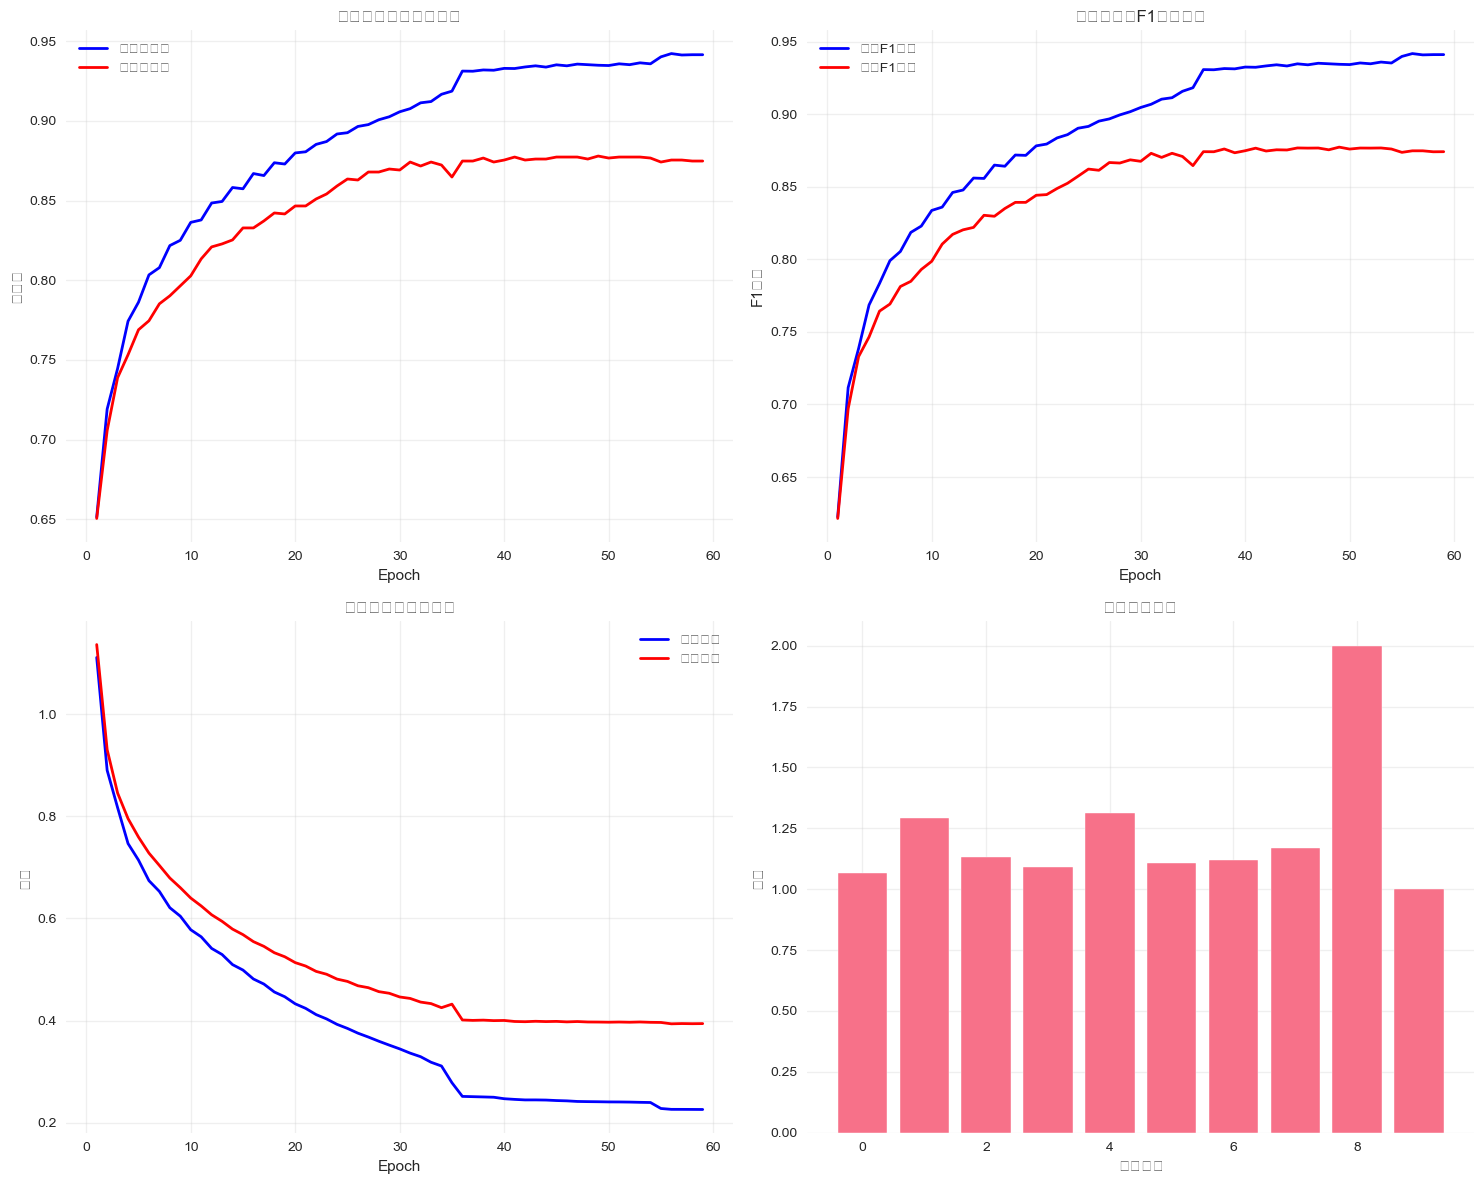


8. 最终模型评估...

训练完成!
总时间: 11657.9秒 (训练: 69.4秒)

训练集指标:
  准确率: 0.9348
  F1分数: 0.9345
  精确率: 0.9345
  召回率: 0.9348

验证集指标:
  准确率: 0.8779
  F1分数: 0.8774
  精确率: 0.8777
  召回率: 0.8779

最佳参数: {'C': 0.008, 'class_weight': {0: 1.0668821109828428, 1: 1.2905546482388799, 2: 1.133747209594108, 3: 1.0895473337252186, 4: 1.3118377699199042, 5: 1.1067790053053448, 6: 1.1202904155074869, 7: 1.1690871794330713, 8: 2.0, 9: 1.0}, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1, 'multi_class': 'deprecated', 'n_jobs': -1, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': True}

过拟合/欠拟合分析:
  训练准确率: 0.9348, 验证准确率: 0.8779, 差距: 0.0569
  训练F1分数: 0.9345, 验证F1分数: 0.8774, 差距: 0.0571
  ℹ️  模型表现正常

绘制交叉验证结果...
------------------------------------------------------------


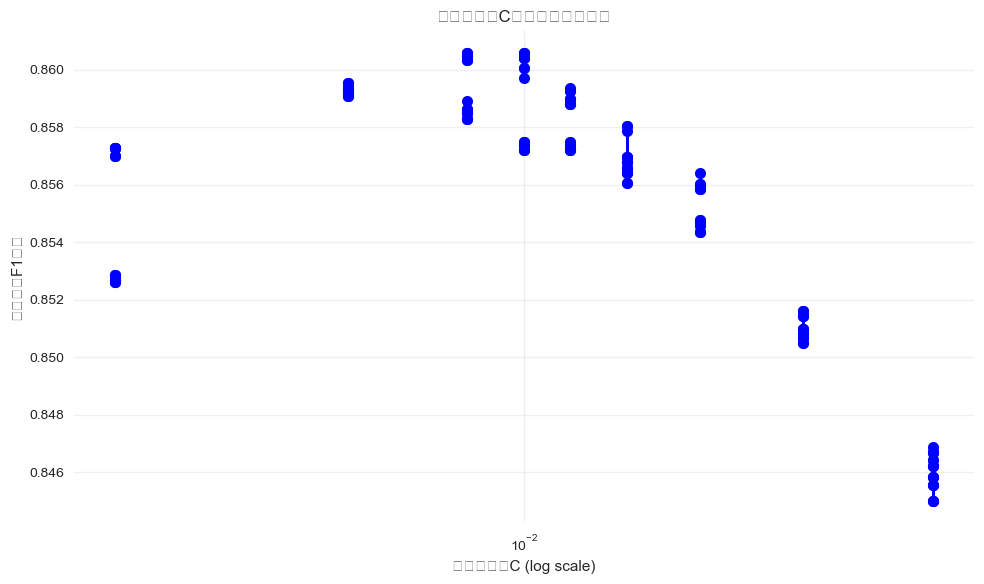


在测试集上进行最终评估...
------------------------------------------------------------
⚠️ 注意：测试集只能使用一次进行最终评估！
------------------------------------------------------------

⚠️ 在测试集上最终评估（测试集只能使用一次）
提取数据特征...


处理批次: 100%|████████████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 4641.70it/s]

测试数据: 3,211 个样本
使用PCA降维: 1965 -> 400 维度

测试集指标:
  准确率: 0.8636
  F1分数: 0.8624
  精确率: 0.8622
  召回率: 0.8636
  评估时间: 0.1秒

详细分类报告:
                                             precision    recall  f1-score   support

                      Tomato_Bacterial_spot     0.8894    0.9227    0.9057       427
                        Tomato_Early_blight     0.6809    0.6400    0.6598       200
                             Tomato_healthy     0.9373    0.9843    0.9602       319
                         Tomato_Late_blight     0.8182    0.7520    0.7837       383
                           Tomato_Leaf_Mold     0.7921    0.8377    0.8142       191
                  Tomato_Septoria_leaf_spot     0.8542    0.8085    0.8307       355
Tomato_Spider_mites_Two_spotted_spider_mite     0.8604    0.8988    0.8792       336
                        Tomato__Target_Spot     0.8542    0.8723    0.8632       282
                Tomato__Tomato_mosaic_virus     0.8873    0.8400    0.8630        75
      Tomato__Tomato_Y

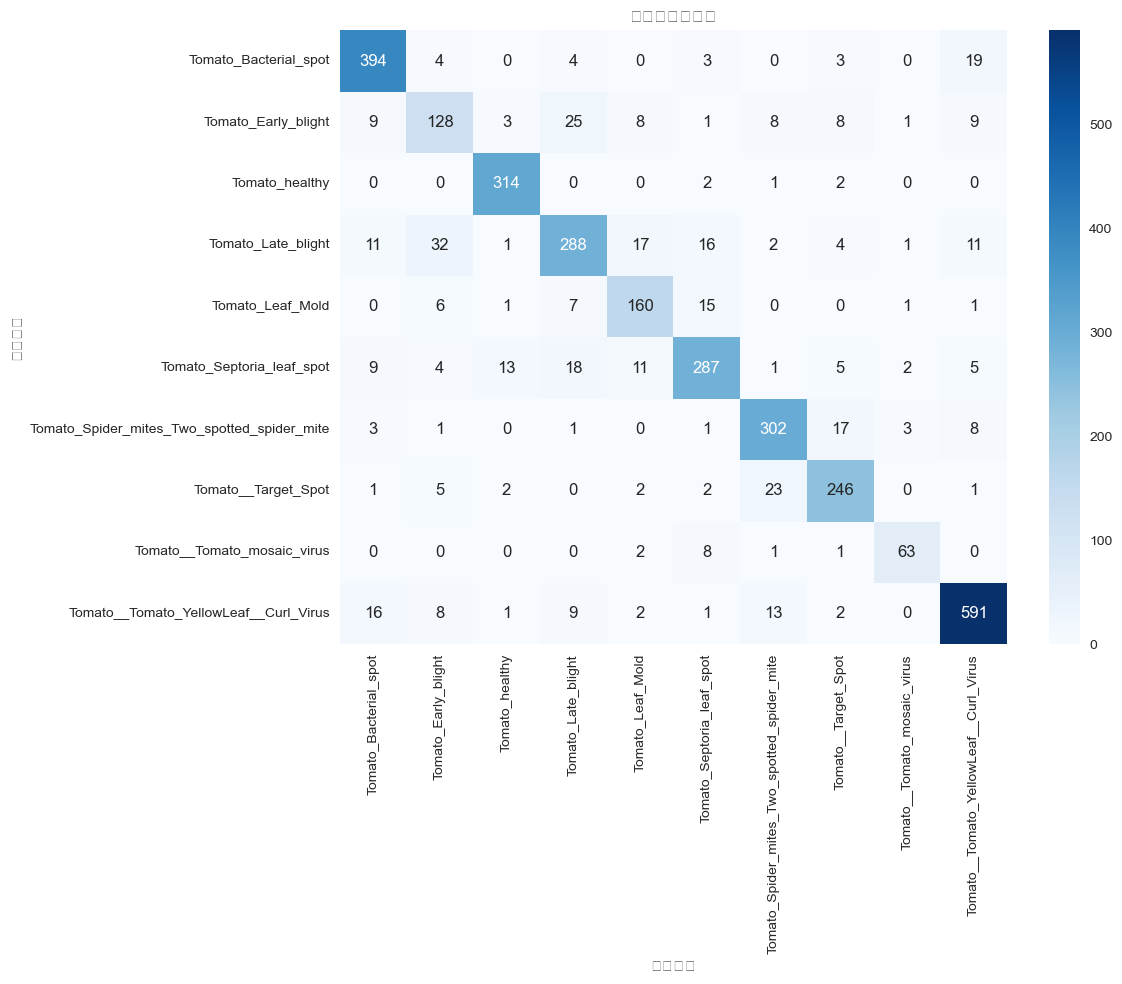


每类性能:
  Tomato_Bacterial_spot: 427个样本, 权重=1.067, 准确率=0.9227, F1分数=0.9057
  Tomato_Early_blight: 200个样本, 权重=1.291, 准确率=0.6400, F1分数=0.6598
  Tomato_healthy: 319个样本, 权重=1.134, 准确率=0.9843, F1分数=0.9602
  Tomato_Late_blight: 383个样本, 权重=1.090, 准确率=0.7520, F1分数=0.7837
  Tomato_Leaf_Mold: 191个样本, 权重=1.312, 准确率=0.8377, F1分数=0.8142
  Tomato_Septoria_leaf_spot: 355个样本, 权重=1.107, 准确率=0.8085, F1分数=0.8307
  Tomato_Spider_mites_Two_spotted_spider_mite: 336个样本, 权重=1.120, 准确率=0.8988, F1分数=0.8792
  Tomato__Target_Spot: 282个样本, 权重=1.169, 准确率=0.8723, F1分数=0.8632
  Tomato__Tomato_mosaic_virus: 75个样本, 权重=2.000, 准确率=0.8400, F1分数=0.8630
  Tomato__Tomato_YellowLeaf__Curl_Virus: 643个样本, 权重=1.000, 准确率=0.9191, F1分数=0.9177

保存训练好的模型...
------------------------------------------------------------
模型已保存到: improved_logistic_regression_cv_model.pkl

模型训练和评估完成!
训练准确率: 0.9348
验证准确率: 0.8779
测试准确率: 0.8636

结果分析:
  训练-验证差距: 0.0569
  验证-测试差距: -0.0143
  ✅  验证集和测试集性能一致

训练时间: 11657.9秒
测试时间: 0.1秒


In [20]:
# %% [markdown]
# ## 6. 训练模型（包含交叉验证和超参数调优）

# %%
print("开始训练模型...")
print("-" * 60)

# 训练模型，包含交叉验证和超参数调优
training_results = improved_model.train_with_validation(
    train_loader=train_loader,
    val_loader=val_loader,
    use_pca=True,
    pca_components_range=[100,200,300,400],  # 调优超参数1: PCA组件数
    cv_folds=5,  # 5-Fold交叉验证
    early_stopping=True,
    patience=10
)

# %%
# 绘制交叉验证结果
print("\n绘制交叉验证结果...")
print("-" * 60)

improved_model.plot_cv_results()

# %% [markdown]
# ## 7. 在测试集上最终评估（只能使用一次）

# %%
print("\n在测试集上进行最终评估...")
print("-" * 60)
print("⚠️ 注意：测试集只能使用一次进行最终评估！")
print("-" * 60)

# 在测试集上评估模型
test_results = improved_model.evaluate_on_test(
    test_loader=test_loader,
    class_names=loaded_class_names
)

# %% [markdown]
# ## 8. 保存模型

# %%
print("\n保存训练好的模型...")
print("-" * 60)

# 保存模型
model_save_path = "improved_logistic_regression_cv_model.pkl"
improved_model.save_model(model_save_path)

# %% [markdown]
# ## 9. 结果分析

# %%
print("\n模型训练和评估完成!")
print("=" * 80)

# 显示最终结果
print(f"训练准确率: {training_results['train_accuracy']:.4f}")
print(f"验证准确率: {training_results['val_accuracy']:.4f}")
print(f"测试准确率: {test_results['accuracy']:.4f}")

# 分析结果
train_val_gap = training_results['train_accuracy'] - training_results['val_accuracy']
test_val_gap = test_results['accuracy'] - training_results['val_accuracy']

print(f"\n结果分析:")
print(f"  训练-验证差距: {train_val_gap:.4f}")
print(f"  验证-测试差距: {test_val_gap:.4f}")

if abs(test_val_gap) > 0.05:
    print(f"  ⚠️  注意：验证集和测试集性能差距较大 ({test_val_gap:.4f})")
    print("  可能原因：验证集和测试集分布不同，或验证集过小")
else:
    print(f"  ✅  验证集和测试集性能一致")

# 显示训练时间
print(f"\n训练时间: {training_results['training_time']:.1f}秒")
print(f"测试时间: {test_results['evaluation_time']:.1f}秒")